In [1]:
import pygot
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from tqdm import tqdm
import pandas as pd
import torch
import scvelo as scv
from scipy.stats import pearsonr, spearmanr
from pygot.tools.analysis import ProbabilityModel
from experimental import *
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
%matplotlib inline

## Synthetic

In [2]:
datasets = ['LI', 'BF', 'LL', 'BFC', 'CY', 'TF']

time_key = 'Day'
embedding_key = 'X_origin'
velocity_key = 'velocity_origin'
experiment_rep = 20


In [3]:


import scvelo as scv

#This function is used to benchmark cycle dataset, adjust for relative ordering
def mod_pseudotime(adata, key):
    p = []
    for i in tqdm(range(len(adata))):
        mod = adata.obs['Time'].tolist()[i]
        mod_time = adata.obs['Time'].copy()
        if len(mod_time[mod_time > mod]) > 0:
            b = max(mod_time[mod_time > mod] - mod)
        else:
            b = 0
        mod_time[adata.obs['Time'] >= mod] -= mod
        mod_time[adata.obs['Time'] < mod] += b
        p.append(spearmanr(adata.obs[key], mod_time)[0])
    best_p = np.argmax(p)
    mod = adata.obs['Time'].tolist()[best_p]
    mod_time = adata.obs['Time'].copy()
    b = max(mod_time[mod_time > mod] - mod)
    mod_time[adata.obs['Time'] >= mod] -= mod
    mod_time[adata.obs['Time'] < mod] += b
    return mod_time


In [4]:
from sklearn.preprocessing import minmax_scale
synthetic_results = []

for i in range(len(datasets)):
    adata, ref_network, pool = experiment('../pygot_data/01_velocity/simulation/inputs/Synthetic/dyn-' + datasets[i] + '_velo' , split_k=6)
    velo = pd.read_csv('../pygot_data/01_velocity/simulation/inputs/Synthetic/dyn-'+ datasets[i] + '_velo/VelocityData.csv', index_col=0)
    true_v = velo.to_numpy().T
    adata.obsm['X_origin'].shape
    velocity_key, embedding_key = 'velocity_origin', 'X_origin'
    

    adata.layers['Ms'] = adata.X
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    
    for j in range(20):
        model, history = pygot.tl.traj.fit_velocity_model(
            adata, time_key, embedding_key, 
            v_centric_iter_n=500, x_centric_iter_n=1000,
        )
        
        torch.save(model, '../pygot_data/01_velocity/simulation/outputs/Synthetic/dyn-' + datasets[i] + '_velo/got_{}.pkl'.format(j))
        model = torch.load('../pygot_data/01_velocity/simulation/outputs/Synthetic/dyn-' + datasets[i] + '_velo/got_{}.pkl'.format(j))
        adata.layers['velocity'] = pygot.tl.traj.latent_velocity(adata, model, 'X_origin', time_key='Day')
        adata.obsm['velocity_origin'] = adata.layers['velocity'] 
        #VPT
        pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
        scv.tl.velocity_pseudotime(adata)
        adata.obs['velocity_pseudotime_{}'.format(j)] = adata.obs['velocity_pseudotime'].copy()
        #GOT
        pm = ProbabilityModel()
        pm.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key, marginal=False)
        adata.obs['got_pseudotime_{}'.format(j)] = pm.estimate_pseudotime(adata, mode='mean')
        adata.obs['got_pseudotime_{}'.format(j)] -= adata.obs['got_pseudotime_{}'.format(j)].min()
        if datasets[i] == 'CY':
            mod_time = mod_pseudotime(adata, 'velocity_pseudotime')
            
            vpt_p = pearsonr(adata.obs['velocity_pseudotime'], mod_time)[0]
            vpt_s = spearmanr(adata.obs['velocity_pseudotime'], mod_time)[0]
            synthetic_results.append([datasets[i],'VPT',  vpt_p, vpt_s])
            print('VPT',vpt_p, vpt_s)

            mod_time = mod_pseudotime(adata, 'got_pseudotime_{}'.format(j))
            
            got_p = pearsonr(adata.obs['got_pseudotime_{}'.format(j)], mod_time)[0]
            got_s = spearmanr(adata.obs['got_pseudotime_{}'.format(j)], mod_time)[0]
            synthetic_results.append([datasets[i], 'GOT', got_p, got_s])
            print('GOT',got_p, got_s)
            
        else:    
            vpt_p = pearsonr(adata.obs['velocity_pseudotime'], adata.obs['Time'])[0]
            vpt_s = spearmanr(adata.obs['velocity_pseudotime'], adata.obs['Time'])[0]
            synthetic_results.append([datasets[i],'VPT',  vpt_p, vpt_s])
            print('VPT',vpt_p, vpt_s)
            
            got_p = pearsonr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
            got_s = spearmanr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
            synthetic_results.append([datasets[i], 'GOT', got_p, got_s])
            print('GOT',got_p, got_s)
    
            if 'velocity_self_transition' in adata.obs.columns:
                del adata.obs['velocity_self_transition']
            del adata.obs['root_cells']
            del adata.obs['end_points']
            
   
    sc.write('./results/02_pseudotime/'+datasets[i]+'_normal.h5ad', adata)  
    

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0008: 100%|██████████████████████████████████████| 500/500 [00:31<00:00, 15.80it/s]


VPT 0.9862311002883972 0.9913934938037979
GOT 0.993020049663435 0.993834159460704
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0013: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.54it/s]


VPT 0.9864326563181846 0.9913944178097254
GOT 0.9923080601400974 0.993756998965718
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0010: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.81it/s]


VPT 0.9859303712807723 0.9912210346974702
GOT 0.9926432423790009 0.9937609409910062
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0010: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.28it/s]


VPT 0.9859549780000505 0.9913991818402866
GOT 0.9929697451925683 0.9937335808154903
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0009: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.33it/s]


VPT 0.9861042260356621 0.9912474588669815
GOT 0.9927383990664606 0.9936475702637314
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0011: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.43it/s]


VPT 0.9859601288132694 0.9913197893309826
GOT 0.9926560647050745 0.993682526487976
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0012: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.72it/s]


VPT 0.9861914524109548 0.9912975651884144
GOT 0.9922999745388814 0.9936432262358645
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0010: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.25it/s]


VPT 0.9861892329931695 0.9912173206736447
GOT 0.992799848417546 0.9937088066565637
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0015: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.96it/s]


VPT 0.9860777403696092 0.9914142599370128
GOT 0.9923356279259106 0.9937660890240311
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0010: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.49it/s]


VPT 0.9861238323077879 0.9912832670966918
GOT 0.992831124347076 0.9937770060753789
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0009: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.00it/s]


VPT 0.9860560213043789 0.99129873519592
GOT 0.9929162687104741 0.9937381408447429
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0014: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.25it/s]


VPT 0.986377926812401 0.9912622789620527
GOT 0.9920498653313442 0.9937826551303028
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0010: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.83it/s]


VPT 0.9863788922221443 0.9913293293921822
GOT 0.992880082819805 0.9938231913903436
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0010: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.58it/s]


VPT 0.9860321353854772 0.9912398268180218
GOT 0.9928951033055775 0.993790305179378
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0015: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.82it/s]


VPT 0.9862758252358915 0.9913310874034599
GOT 0.9907260309997016 0.993546883617825
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0011: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.56it/s]


VPT 0.9865497326533307 0.9913832757382487
GOT 0.9929521404114776 0.993825411404585
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0009: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.15it/s]


VPT 0.9860013750788796 0.9912955191752892
GOT 0.992913366876982 0.9937493189164505
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0014: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.79it/s]


VPT 0.9866536317455123 0.9914024878614949
GOT 0.9906273356221631 0.9935692367419122
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0014: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.03it/s]


VPT 0.9864689415362498 0.9912894591364141
GOT 0.9919083657084086 0.9937460548955117
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0010: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.09it/s]


VPT 0.9865271405551783 0.9913724756689661
GOT 0.9928490021361938 0.9936893965320475
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0022: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.95it/s]


VPT 0.8055013466603879 0.7583700857185927
GOT 0.9318147832548418 0.907095826619024
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0014: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.93it/s]


VPT 0.802869608169914 0.7120501045033026
GOT 0.9417102275938745 0.9154347647226186
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0041: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.07it/s]


VPT 0.8128854863784105 0.7598049008982802
GOT 0.9364708603324736 0.9077925071340429
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0023: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.17it/s]


VPT 0.8188364910479528 0.7829801225609094
GOT 0.9115342796168109 0.8949086006230965
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0030: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.48it/s]


VPT 0.7941704695031998 0.8007981348839947
GOT 0.941028394477053 0.9089426272859805
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0028: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.95it/s]


VPT 0.8028235352127878 0.8429580370813851
GOT 0.9380301302138955 0.907235827846129
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0008: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.81it/s]


VPT 0.7855381359387825 0.851628626382242
GOT 0.9459394880333596 0.9170081564025682
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0016: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.42it/s]


VPT 0.814713766112118 0.8541808435957549
GOT 0.9426824937497874 0.9157484363494507
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0031: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.00it/s]


VPT 0.8461127892167516 0.8671177002978515
GOT 0.9442532427445909 0.9142986933642862
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0027: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.18it/s]


VPT 0.7906262592952495 0.7906001560692564
GOT 0.9415642879119933 0.9090624414456902
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0019: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.76it/s]


VPT 0.8231378350063245 0.7878094199946896
GOT 0.9344446902144867 0.9093602767936967
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0016: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.42it/s]


VPT 0.8134254805497285 0.8267869347036504
GOT 0.9354856803345951 0.9064405814115304
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0029: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.88it/s]


VPT 0.8145501734564511 0.8459263917971558
GOT 0.926049288709899 0.894913958642439
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0031: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.92it/s]


VPT 0.7963581305467159 0.7300115173440641
GOT 0.9425697912243807 0.9044586310987389
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0015: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.94it/s]


VPT 0.7868063602969672 0.7506013536734434
GOT 0.9390763068911343 0.9064230081901471
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0014: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.63it/s]


VPT 0.8043974605097661 0.7503082166152176
GOT 0.9232509154561853 0.8994918491686393
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0028: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.30it/s]


VPT 0.8494628616926913 0.8693281382775402
GOT 0.931061996369039 0.9030559640351061
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0027: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.14it/s]


VPT 0.8219145628509673 0.8432987723114405
GOT 0.9302967706620162 0.9034825895752256
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0018: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.57it/s]


VPT 0.8141404171787355 0.8138375319562625
GOT 0.9386266809841058 0.9101214842720154
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0023: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.37it/s]


VPT 0.788307467280086 0.7733007016181669
GOT 0.9379280851689817 0.9105881812264358
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 15.11it/s]


VPT 0.06316954597003266 0.041527327561052416
GOT 0.9562618210290877 0.998196859146415
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 15.02it/s]


VPT 0.10214199398633217 0.05485562722440725
GOT 0.9951230639694661 0.9980757449553566
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.28it/s]


VPT 0.13324163330169222 0.07182735884191088
GOT 0.982416906954466 0.9977129790500828
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0004: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 14.80it/s]


VPT 0.09341866555620658 0.05752439053689905
GOT 0.9909144649017474 0.9974208354130238
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0004: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 14.98it/s]


VPT 0.09663567140375705 0.057929023025504386
GOT 0.9831394781253274 0.9984049357278432
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 14.81it/s]


VPT 0.07154964700569412 0.050831460352941234
GOT 0.9877497519015648 0.9981027064177644
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0007: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 14.79it/s]


VPT 0.08826382427507032 0.06033668683277232
GOT 0.9633145491358456 0.9954465391135651
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0003: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.37it/s]


VPT 0.13855027822397795 0.08267246331493962
GOT 0.9909550051928753 0.9981292219907761
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 15.15it/s]


VPT 0.1316292493708935 0.0808937556995124
GOT 0.9787365029289573 0.9982748747531391
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0004: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 15.12it/s]


VPT 0.1055724285130981 0.0595577074310552
GOT 0.9923103980970268 0.9983858334930454
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0003: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 14.90it/s]


VPT 0.15312825347967102 0.1071132985162709
GOT 0.9854379418098724 0.9983945348321072
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0005: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 15.02it/s]


VPT 0.11629431404192644 0.06340810263256595
GOT 0.9906909639866677 0.9977347215088411
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0005: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 14.97it/s]


VPT 0.11595658538880112 0.06616943778377866
GOT 0.989483476576111 0.9967600386449523
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0008: 100%|██████████████████████████████████████| 500/500 [00:34<00:00, 14.59it/s]


VPT 0.12180717736726442 0.07507267386729931
GOT 0.99369657544519 0.9974812318972361
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 15.06it/s]


VPT 0.1039504269024038 0.06006592176562971
GOT 0.9782456225776208 0.9977351380644193
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0005: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 14.90it/s]


VPT 0.1255434745460747 0.08416960274500107
GOT 0.9814415426692146 0.9976095578708861
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 15.08it/s]


VPT 0.12121858514030728 0.06694344962666993
GOT 0.9724313701610138 0.9945274409529364
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.23it/s]


VPT 0.11999626795525274 0.07393085089337678
GOT 0.9939540126156909 0.9980609895014119
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0005: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.37it/s]


VPT 0.11945481084276423 0.0607816871257309
GOT 0.9824388136165383 0.9976295088837571
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 14.79it/s]


VPT 0.11433582657567931 0.06734991678314975
GOT 0.9606568522854113 0.9981072408651941
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0015: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.07it/s]


VPT 0.9819112603110743 0.9916136878988069
GOT 0.9772690190216177 0.9941784634115687
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0011: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.09it/s]


VPT 0.3563208099508991 0.03540064130110848
GOT 0.9882242592446122 0.9938675242582943
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0014: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.37it/s]


VPT 0.9792196411293117 0.9913956350900484
GOT 0.9821567390751953 0.9941402372697877
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0007: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.01it/s]


VPT 0.9830882606016246 0.991567409727161
GOT 0.9931744743694544 0.9942358356243626
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0009: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.45it/s]


VPT 0.9807832510083208 0.9917903405540123
GOT 0.985944251850974 0.9940035867629505
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0018: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.46it/s]


VPT 0.3695264404044379 0.048906565394630494
GOT 0.9454025656032732 0.9513664566216786
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0018: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.22it/s]


VPT 0.9809812280954116 0.991303894749783
GOT 0.9751705362128898 0.994322883947225
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0009: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.64it/s]


VPT 0.3759864761700617 0.059822435881634196
GOT 0.9892447097598792 0.9940978111124291
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0016: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.02it/s]


VPT 0.39663067958299403 0.08265359456248551
GOT 0.9438297087781308 0.9536312487435727
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0007: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.85it/s]


VPT 0.37362426612687455 0.06473691010943713
GOT 0.9929732725714412 0.9944891625639529
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0011: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.86it/s]


VPT 0.9799668467470832 0.991318864805307
GOT 0.9907182932409578 0.9939786986706406
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0011: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.27it/s]


VPT 0.978024874148065 0.9912866986860026
GOT 0.985256613083469 0.9942039335060374
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0009: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.91it/s]


VPT 0.9806727246270722 0.9914288092130912
GOT 0.992016295967853 0.9943126899094151
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0010: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.53it/s]


VPT 0.3481122529679073 0.07605283208023325
GOT 0.985017323242466 0.9942415896457042
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0010: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.41it/s]


VPT 0.29944220008878564 0.12153325276728047
GOT 0.9887795959196728 0.9943394440086463
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0011: 100%|██████████████████████████████████████| 500/500 [00:26<00:00, 18.72it/s]


VPT 0.9814797439356667 0.9915726897467446
GOT 0.9832597936792746 0.9943646470852104
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0007: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.07it/s]


VPT 0.9814621558745339 0.9912935927115727
GOT 0.9930354954310451 0.9943358439782933
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0006: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.19it/s]


VPT 0.9818059691218511 0.9912695806225117
GOT 0.9917762189398331 0.9943418680176369
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0009: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.53it/s]


VPT 0.35454431898738814 0.09407317291774353
GOT 0.9858664350602149 0.9941343992481346
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0009: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.54it/s]


VPT 0.9779363772308332 0.9915522596709694
GOT 0.98208915269297 0.9943782761526748
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 181.85it/s]


VPT 0.7400237711919248 0.8154715106944105


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.75it/s]


GOT 0.5676084026755235 0.609449928407455
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.76it/s]


VPT 0.7612926752631365 0.8399757113168383


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.18it/s]


GOT 0.7269374986535371 0.7286882779154037
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 182.35it/s]


VPT 0.7116010610810117 0.8004185974823139


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.95it/s]


GOT 0.5293151430822246 0.49815628797300876
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.26it/s]


VPT 0.8057519062172365 0.8957217823793787


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 182.86it/s]


GOT 0.7061924422710095 0.7206124953674865
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 182.73it/s]


VPT 0.7484683075389412 0.8335504506035212


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.90it/s]


GOT 0.7895486998249209 0.7940733451984687
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.75it/s]


VPT 0.8074179706399167 0.8893601758910793


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.50it/s]


GOT 0.6896055841980386 0.7150930458562148
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 178.47it/s]


VPT 0.7981372166775632 0.878009305765717


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 181.20it/s]


GOT 0.6193408255118762 0.6415893608699786
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.76it/s]


VPT 0.7436819942200895 0.8403456366245255


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.46it/s]


GOT 0.7523844662982132 0.7090909507660568
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.74it/s]


VPT 0.772203084987167 0.8653879311491173


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.54it/s]


GOT 0.5921438400056619 0.6153052171059195
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 181.96it/s]


VPT 0.7465315261429593 0.8521293302799205


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.26it/s]


GOT 0.6236212379737559 0.6875714345672304
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.45it/s]


VPT 0.7801246040872039 0.861201902351492


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.14it/s]


GOT 0.8026345452737378 0.7667775211616545
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.20it/s]


VPT 0.8214177303092388 0.9055489651185014


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.62it/s]


GOT 0.8246484692235871 0.8346658150503291
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.28it/s]


VPT 0.7517775101003515 0.832687431552746


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 181.17it/s]


GOT 0.6279598237587013 0.6450322021909074
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.86it/s]


VPT 0.780660644827132 0.8749135408221779


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.48it/s]


GOT 0.7145292150418102 0.7060324720632413
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.19it/s]


VPT 0.7409148450673257 0.8250786726557588


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 182.05it/s]


GOT 0.386433955760644 0.47957200360471075
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.11it/s]


VPT 0.7600061666534618 0.876650108960952


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 182.96it/s]


GOT 0.7971693919981623 0.7686328087312337
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.27it/s]


VPT 0.8278962996952349 0.8999637853748731


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.02it/s]


GOT 0.705557360551879 0.6872146875526839
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.07it/s]


VPT 0.7189920333536963 0.7934019026782752


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.18it/s]


GOT 0.8651677029895157 0.8745994385832004
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.72it/s]


VPT 0.7861437786633879 0.8754277486399044


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 175.93it/s]


GOT 0.672672418783229 0.6316391468464136
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
Device: cuda


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 180.67it/s]


VPT 0.7273434719276334 0.8270729837056549


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 178.65it/s]


GOT 0.7437095803444438 0.7238443287920281
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0027: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.49it/s]


VPT 0.6257293385358887 0.5048643885621624
GOT 0.947312812816355 0.9259245331462512
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0027: 100%|██████████████████████████████████████| 500/500 [00:27<00:00, 18.15it/s]


VPT 0.7481906492093935 0.8217701425930138
GOT 0.9486648811665578 0.9226813448827977
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0024: 100%|██████████████████████████████████████| 500/500 [00:27<00:00, 18.48it/s]


VPT 0.7288819295902389 0.8572747367647198
GOT 0.948663626585303 0.9236366803315621
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0051: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.09it/s]


VPT 0.7479440155168644 0.6589290687361825
GOT 0.94796197658589 0.922461234088197
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0023: 100%|██████████████████████████████████████| 500/500 [00:27<00:00, 17.92it/s]


VPT 0.7454504707360404 0.8356762307940397
GOT 0.9451582878034616 0.9212634045278113
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0035: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.07it/s]


VPT 0.7396602624751943 0.5893178554394655
GOT 0.9483228849944978 0.9273212096327254
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0028: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.76it/s]


VPT 0.7348220320344059 0.5987429294640148
GOT 0.9516367218155111 0.9273586797679927
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0016: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.79it/s]


VPT 0.7683611907240564 0.7410446511737149
GOT 0.9488935815202182 0.9276520028268899
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0015: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.04it/s]


VPT 0.7522566516394054 0.6750491829298496
GOT 0.9485109512557004 0.927113836884109
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0031: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.74it/s]


VPT 0.7069331056641841 0.5717602380564069
GOT 0.9469648757410714 0.9291803583442586
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0026: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.25it/s]


VPT 0.7356521710178775 0.776276514360861
GOT 0.946709897741164 0.9275910546068667
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0018: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.21it/s]


VPT 0.7667713808362945 0.7452306622852293
GOT 0.9480542377099052 0.9285180519533303
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0044: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.49it/s]


VPT 0.7653564970307342 0.7501361299939843
GOT 0.9504283511602332 0.9217684595872789
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0022: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.15it/s]


VPT 0.7478512595179357 0.7338529232115524
GOT 0.9508517111391775 0.9242408732854159
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0047: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.87it/s]


VPT 0.746433147040478 0.7082274427034805
GOT 0.8982947038698849 0.8530291719972972
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0022: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.32it/s]


VPT 0.7529754340586723 0.5850913441817454
GOT 0.9473606841571166 0.9211560673765408
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0049: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.57it/s]


VPT 0.7336789456423997 0.5620231029053159
GOT 0.9471198922088911 0.9124413599164172
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0020: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.55it/s]


VPT 0.7731515311878631 0.7469508324950496
GOT 0.9457152760936567 0.9230054720528981
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0021: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.63it/s]


VPT 0.7413795466064623 0.6503509637691944
GOT 0.9484690456990305 0.9254700229499351
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0016: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.22it/s]


VPT 0.7017580000968269 0.5562714941419886
GOT 0.9488260843018078 0.93471328431814


In [4]:
synthetic_results = []
for i in range(len(datasets)):
    adata = sc.read('./results/02_pseudotime/'+datasets[i]+'_normal.h5ad')
    for j in range(20):
        if datasets[i] =='CY':
            mod_time = mod_pseudotime(adata, 'velocity_pseudotime_{}'.format(j))
            vpt_p = pearsonr(adata.obs['velocity_pseudotime_{}'.format(j)], mod_time)[0]
            vpt_s = spearmanr(adata.obs['velocity_pseudotime_{}'.format(j)], mod_time)[0]
            synthetic_results.append([datasets[i],'VPT',  vpt_p, vpt_s])
            print('VPT',vpt_p, vpt_s)

            mod_time = mod_pseudotime(adata, 'got_pseudotime_{}'.format(j))
            
            got_p = pearsonr(adata.obs['got_pseudotime_{}'.format(j)], mod_time)[0]
            got_s = spearmanr(adata.obs['got_pseudotime_{}'.format(j)], mod_time)[0]
            synthetic_results.append([datasets[i], 'GOT', got_p, got_s])
            print('GOT',got_p, got_s)
        else:
            
            vpt_p = pearsonr(adata.obs['velocity_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
            vpt_s = spearmanr(adata.obs['velocity_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
            synthetic_results.append([datasets[i],'VPT',  vpt_p, vpt_s])
            print('VPT',vpt_p, vpt_s)
        
            got_p = pearsonr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
            got_s = spearmanr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
            synthetic_results.append([datasets[i], 'GOT', got_p, got_s])
            print('GOT',got_p, got_s)

VPT 0.9862311002883972 0.9913934938037979
GOT 0.993020049663435 0.993834159460704
VPT 0.9864326563181846 0.9913944178097254
GOT 0.9923080601400974 0.993756998965718
VPT 0.9859303712807723 0.9912210346974702
GOT 0.9926432423790009 0.9937609409910062
VPT 0.9859549780000505 0.9913991818402866
GOT 0.9929697451925683 0.9937335808154903
VPT 0.9861042260356621 0.9912474588669815
GOT 0.9927383990664606 0.9936475702637314
VPT 0.9859601288132694 0.9913197893309826
GOT 0.9926560647050745 0.993682526487976
VPT 0.9861914524109548 0.9912975651884144
GOT 0.9922999745388814 0.9936432262358645
VPT 0.9861892329931695 0.9912173206736447
GOT 0.992799848417546 0.9937088066565637
VPT 0.9860777403696092 0.9914142599370128
GOT 0.9923356279259106 0.9937660890240311
VPT 0.9861238323077879 0.9912832670966918
GOT 0.992831124347076 0.9937770060753789
VPT 0.9860560213043789 0.99129873519592
GOT 0.9929162687104741 0.9937381408447429
VPT 0.986377926812401 0.9912622789620527
GOT 0.9920498653313442 0.9937826551303028
V

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.50it/s]


VPT 0.7400237711919248 0.8154715106944105


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.16it/s]


GOT 0.5676084026755235 0.609449928407455


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.33it/s]


VPT 0.7612926752631365 0.8399757113168383


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.26it/s]


GOT 0.7269374986535371 0.7286882779154037


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.81it/s]


VPT 0.7116010610810117 0.8004185974823139


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.77it/s]


GOT 0.5293151430822246 0.49815628797300876


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.76it/s]


VPT 0.8057519062172365 0.8957217823793787


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.26it/s]


GOT 0.7061924422710095 0.7206124953674865


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.86it/s]


VPT 0.7484683075389412 0.8335504506035212


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.87it/s]


GOT 0.7895486998249209 0.7940733451984687


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.67it/s]


VPT 0.8074179706399167 0.8893601758910793


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 183.66it/s]


GOT 0.6896055841980386 0.7150930458562148


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.80it/s]


VPT 0.7981372166775632 0.878009305765717


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.08it/s]


GOT 0.6193408255118762 0.6415893608699786


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.98it/s]


VPT 0.7436819942200895 0.8403456366245255


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.21it/s]


GOT 0.7523844662982132 0.7090909507660568


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.37it/s]


VPT 0.772203084987167 0.8653879311491173


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.70it/s]


GOT 0.5921438400056619 0.6153052171059195


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.14it/s]


VPT 0.7465315261429593 0.8521293302799205


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.75it/s]


GOT 0.6236212379737559 0.6875714345672304


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.79it/s]


VPT 0.7801246040872039 0.861201902351492


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.81it/s]


GOT 0.8026345452737378 0.7667775211616545


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.48it/s]


VPT 0.8214177303092388 0.9055489651185014


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.55it/s]


GOT 0.8246484692235871 0.8346658150503291


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.91it/s]


VPT 0.7517775101003515 0.832687431552746


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.96it/s]


GOT 0.6279598237587013 0.6450322021909074


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.72it/s]


VPT 0.780660644827132 0.8749135408221779


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 185.16it/s]


GOT 0.7145292150418102 0.7060324720632413


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.10it/s]


VPT 0.7409148450673257 0.8250786726557588


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.07it/s]


GOT 0.386433955760644 0.47957200360471075


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.27it/s]


VPT 0.7600061666534618 0.876650108960952


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.93it/s]


GOT 0.7971693919981623 0.7686328087312337


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 184.75it/s]


VPT 0.8278962996952349 0.8999637853748731


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.50it/s]


GOT 0.705557360551879 0.6872146875526839


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.51it/s]


VPT 0.7189920333536963 0.7934019026782752


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.26it/s]


GOT 0.8651677029895157 0.8745994385832004


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.00it/s]


VPT 0.7861437786633879 0.8754277486399044


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.49it/s]


GOT 0.672672418783229 0.6316391468464136


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.03it/s]


VPT 0.7273434719276334 0.8270729837056549


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 186.13it/s]


GOT 0.7437095803444438 0.7238443287920281
VPT 0.6257293385358887 0.5048643885621624
GOT 0.947312812816355 0.9259245331462512
VPT 0.7481906492093935 0.8217701425930138
GOT 0.9486648811665578 0.9226813448827977
VPT 0.7288819295902389 0.8572747367647198
GOT 0.948663626585303 0.9236366803315621
VPT 0.7479440155168644 0.6589290687361825
GOT 0.94796197658589 0.922461234088197
VPT 0.7454504707360404 0.8356762307940397
GOT 0.9451582878034616 0.9212634045278113
VPT 0.7396602624751943 0.5893178554394655
GOT 0.9483228849944978 0.9273212096327254
VPT 0.7348220320344059 0.5987429294640148
GOT 0.9516367218155111 0.9273586797679927
VPT 0.7683611907240564 0.7410446511737149
GOT 0.9488935815202182 0.9276520028268899
VPT 0.7522566516394054 0.6750491829298496
GOT 0.9485109512557004 0.927113836884109
VPT 0.7069331056641841 0.5717602380564069
GOT 0.9469648757410714 0.9291803583442586
VPT 0.7356521710178775 0.776276514360861
GOT 0.946709897741164 0.9275910546068667
VPT 0.7667713808362945 0.7452306622852293


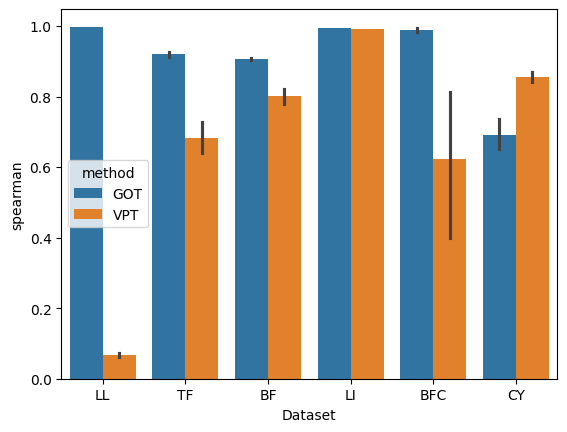

In [5]:
plot_result = pd.DataFrame(synthetic_results, columns=['Dataset', 'method', 'pearson', 'spearman'])
sns.barplot(plot_result, hue='method', y='spearman', x='Dataset',order=['LL', 'TF', 'BF', 'LI', 'BFC', 'CY'], hue_order=['GOT', "VPT"])
plt.show()

In [7]:
plot_result.to_csv('./results/02_pseudotime/synthetic_results.csv')

In [8]:
synthetic_results = pd.read_csv('./results/02_pseudotime/synthetic_results.csv', index_col=0)
synthetic_results

Dataset method   pearson  spearman
0        LI    VPT  0.986231  0.991393
1        LI    GOT  0.993020  0.993834
2        LI    VPT  0.986433  0.991394
3        LI    GOT  0.992308  0.993757
4        LI    VPT  0.985930  0.991221
..      ...    ...       ...       ...
235      TF    GOT  0.945715  0.923005
236      TF    VPT  0.741380  0.650351
237      TF    GOT  0.948469  0.925470
238      TF    VPT  0.701758  0.556271
239      TF    GOT  0.948826  0.934713

[240 rows x 4 columns]

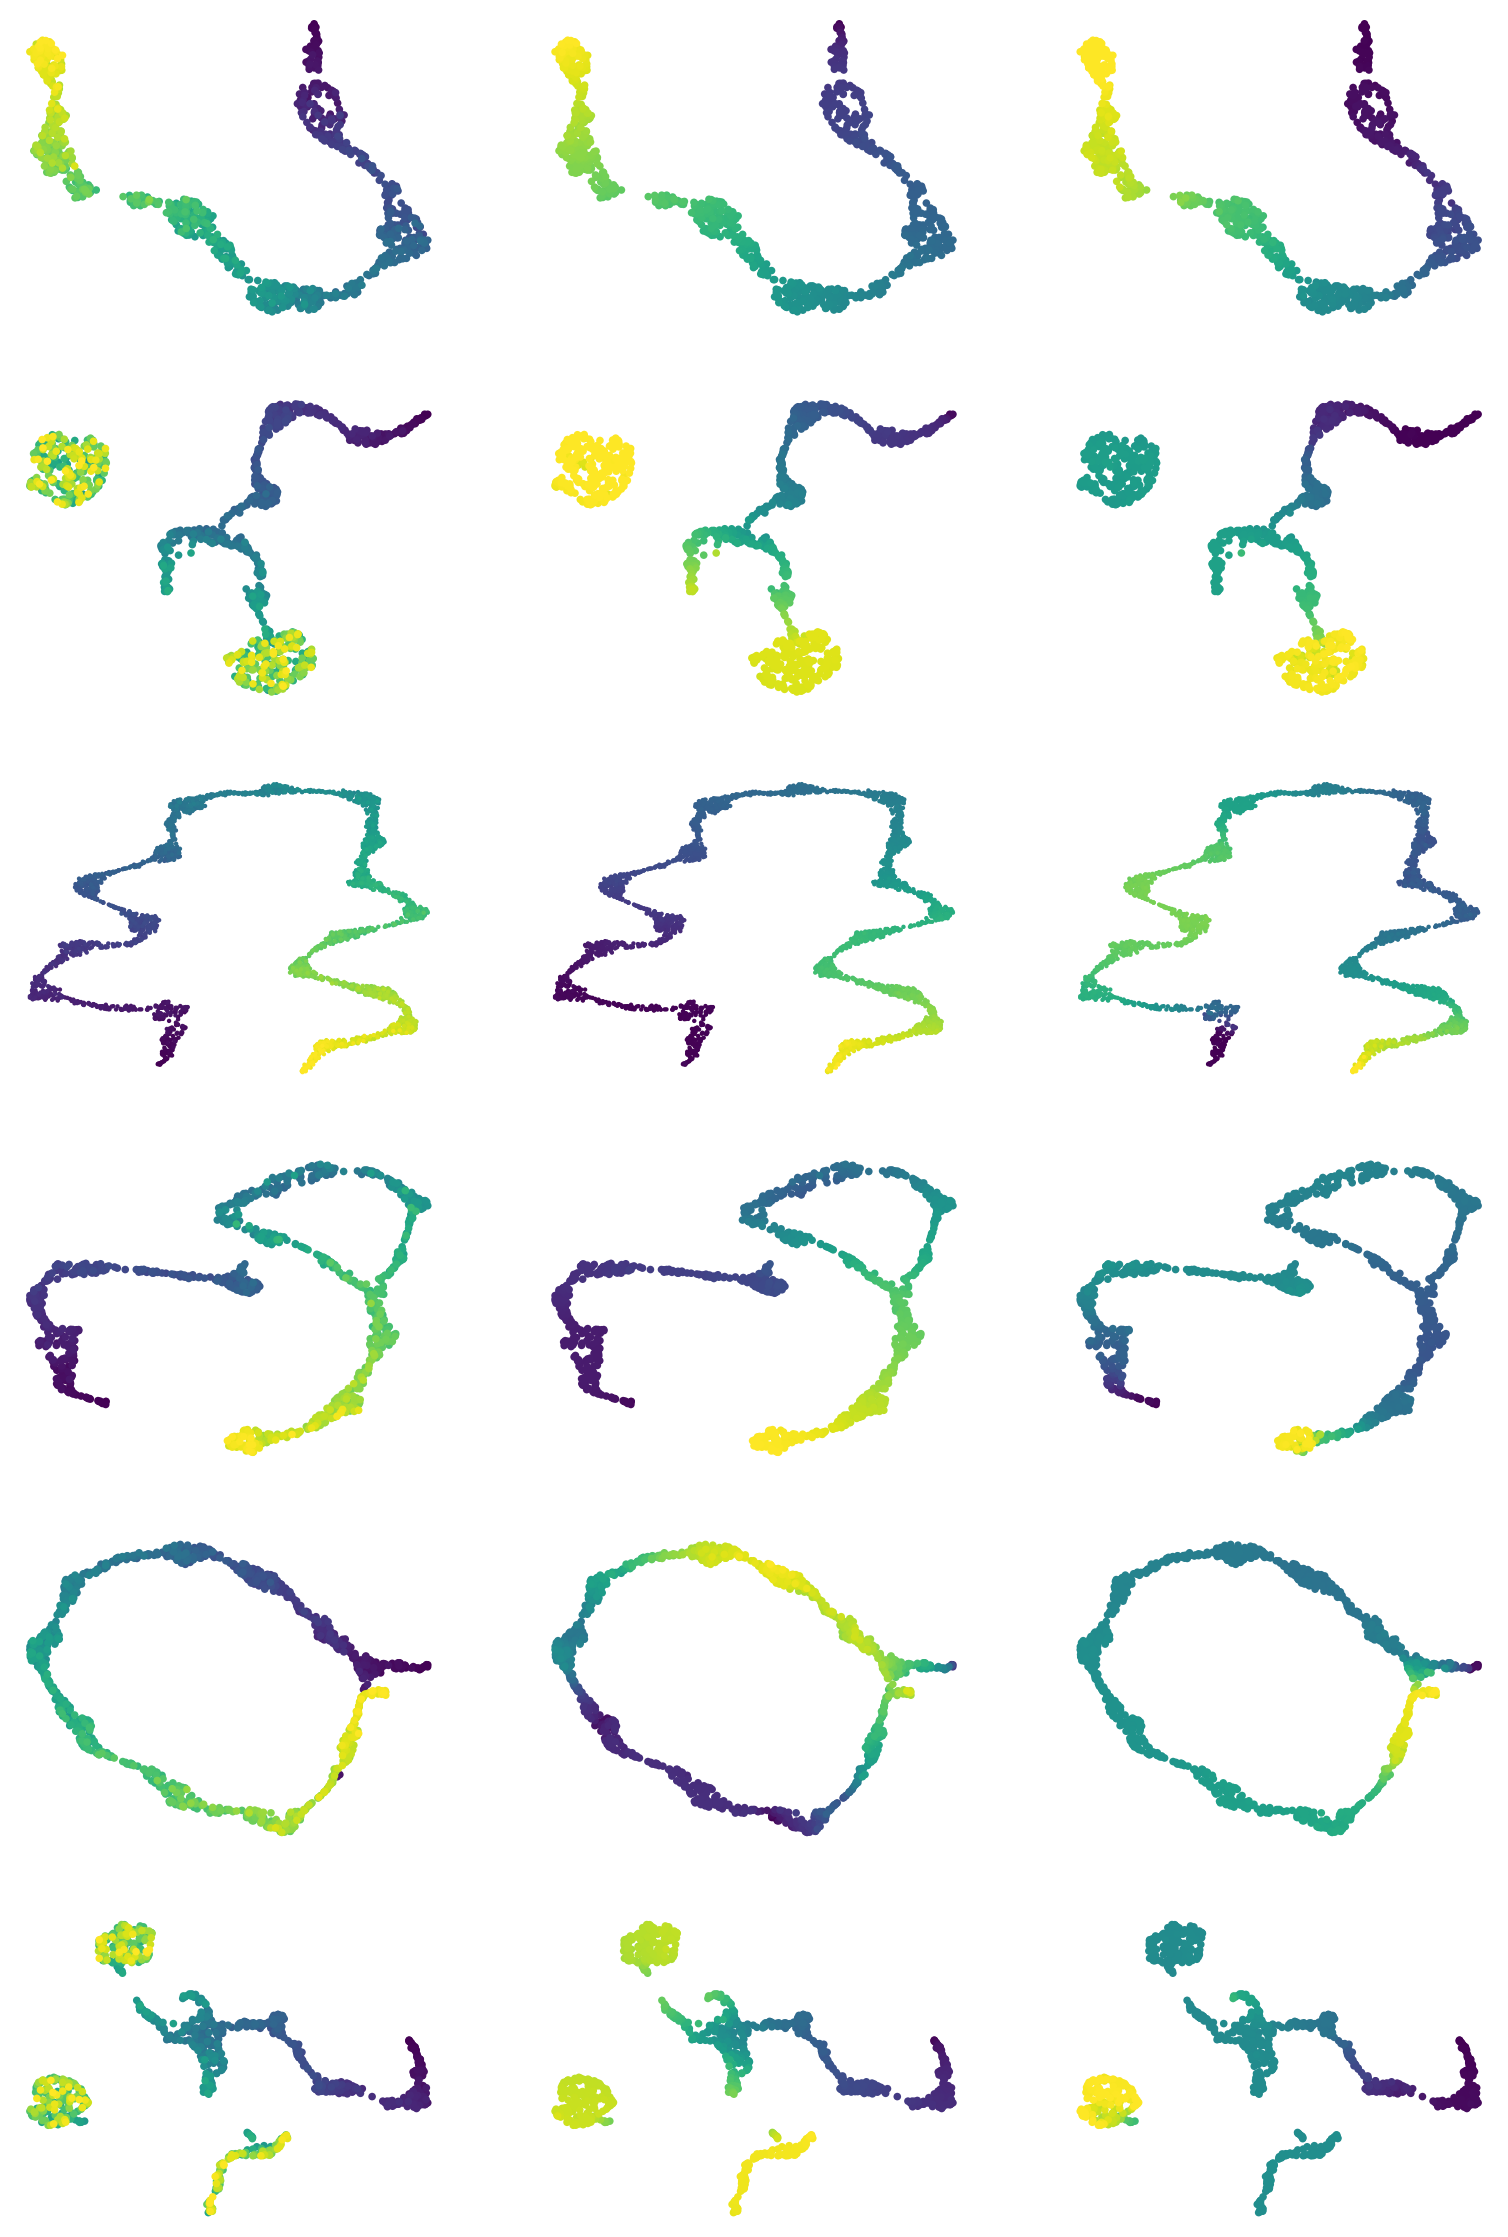

In [6]:
fig, axes = plt.subplots(len(datasets), 3, figsize=(6.4*3 , 4.8 * len(datasets) ))
for i in range(len(datasets)):
    adata = sc.read('./results/02_pseudotime/'+datasets[i]+'_normal.h5ad')
    sc.pl.umap(adata, color='Time', ax=axes[i][0],  title='', show=False, colorbar_loc=None, frameon=False)
    sc.pl.umap(adata, color='got_pseudotime_1', title='', ax=axes[i][1],  show=False, colorbar_loc=None, frameon=False)
    sc.pl.umap(adata, color='velocity_pseudotime_1', title='', ax=axes[i][2], show=False, colorbar_loc=None, frameon=False)
plt.show()

## Curated

In [7]:
datasets = [ 'HSC', 'VSC', 'GSD', 'mCAD']


In [13]:

curated_results = []

for i in range(len(datasets)):
    
    
    adata, ref_network, pool = experiment('../pygot_data/01_velocity/simulation/inputs/Curated/' + datasets[i] + '_velo' , split_k=6)
    velo = pd.read_csv('../pygot_data/01_velocity/simulation/inputs/Curated/'+ datasets[i] + '_velo/VelocityData.csv', index_col=0)
    true_v = velo.to_numpy().T
    adata.obsm['X_origin'].shape
    velocity_key, embedding_key = 'velocity_origin', 'X_origin'

    adata.layers['Ms'] = adata.X
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    
    for j in range(20):
        
        model, history = pygot.tl.traj.fit_velocity_model(
            adata, 'Day', embedding_key, 
            v_centric_iter_n=500, x_centric_iter_n=1000,
        )
        
        torch.save(model, '../pygot_data/01_velocity/simulation/outputs/Curated/' + datasets[i] + '_velo/got_{}.pkl'.format(j))
        model = torch.load('../pygot_data/01_velocity/simulation/outputs/Curated/' + datasets[i] + '_velo/got_{}.pkl'.format(j))
        
        adata.layers['velocity'] = pygot.tl.traj.latent_velocity(adata, model, 'X_origin', time_key='Day')
        adata.obsm['velocity_origin'] = adata.layers['velocity']
        #VPT
        pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
        scv.tl.velocity_pseudotime(adata)
        vpt_p = pearsonr(adata.obs['velocity_pseudotime'], adata.obs['Time'])[0]
        vpt_s = spearmanr(adata.obs['velocity_pseudotime'], adata.obs['Time'])[0]
        print(vpt_p, vpt_s)
        curated_results.append([datasets[i],'VPT',  vpt_p, vpt_s])
        adata.obs['velocity_pseudotime_{}'.format(j)] = adata.obs['velocity_pseudotime'].copy()
        if 'velocity_self_transition' in adata.obs.columns:
            del adata.obs['velocity_self_transition']
        del adata.obs['root_cells']
        del adata.obs['end_points']

        #GOT
        pm = ProbabilityModel()
        pm.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key,  marginal=False, n_iters=500)
        adata.obs['got_pseudotime_{}'.format(j)] = pm.estimate_pseudotime(adata, mode='mean')
        adata.obs['got_pseudotime_{}'.format(j)] = (adata.obs['got_pseudotime_{}'.format(j)] - np.min(adata.obs['got_pseudotime_{}'.format(j)])) / \
            (np.max(adata.obs['got_pseudotime_{}'.format(j)]) - np.min(adata.obs['got_pseudotime_{}'.format(j)]))
        got_p = pearsonr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
        got_s = spearmanr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
        print(got_p, got_s)
        curated_results.append([datasets[i], 'GOT', got_p, got_s])
        #sc.pl.umap(adata, color=['velocity_pseudotime', 'got_pseudotime', 'Time'])

    
    
    sc.write('./results/02_pseudotime/'+datasets[i]+'_normal.h5ad', adata)    

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42566169565033013 0.48955684967296853
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3262: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.74it/s]


0.6114939233847253 0.5409799773326641
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.41454889706093545 0.4906280037069388
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2565: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.59it/s]


0.4149666518003027 0.44005438924651324
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4151568628298131 0.4700680502780756
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2369: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.29it/s]


0.5490843706374376 0.4850440586777804
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4196898230652769 0.4842813478054084
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1665: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.41it/s]


0.2612616883552748 0.3236448968479196
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42095453348973216 0.47594216240000425
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1768: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.13it/s]


0.5846825549196877 0.508058760875409
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4244975202655015 0.47355515541052684
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2183: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.48it/s]


0.5414149855006098 0.4872230148837378
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4097057279210029 0.46192157359841324
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1159: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.49it/s]


0.49092316138910286 0.4940822107154956
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4298893933003728 0.48695337986829135
Device: cuda


Density Loss 0.0000, Taylor Loss 0.4445: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.32it/s]


0.5492168704644241 0.4914726388878381
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4173480568035034 0.473084543638201
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2986: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.03it/s]


0.5418247458815533 0.5047174607678879
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4251441606012712 0.4863906197489346
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1772: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.20it/s]


0.5546947174731031 0.4736882839118892
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42253609620715543 0.4684884423292659
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2075: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.46it/s]


0.48020918122606526 0.4723636829234369
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3927702553649812 0.4408191341265454
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1305: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.41it/s]


0.5417841827650222 0.5142503986689686
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.41588818254862336 0.47196490942165426
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2055: 100%|██████████████████████████████████████| 500/500 [00:27<00:00, 18.26it/s]


0.478406806992638 0.4753448601505617
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.41583014404076185 0.48247417699959627
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3445: 100%|██████████████████████████████████████| 500/500 [00:27<00:00, 17.93it/s]


0.41134799867977795 0.4381539900896027
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.43679204566455787 0.48265654768640487
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1457: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.06it/s]


0.560552281359089 0.49892827896580716
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 3 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.41720214715583126 0.4760248907115594
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1655: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.34it/s]


0.5633324873644162 0.5066400120082233
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4311550285389209 0.47581847193418547
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3112: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.95it/s]


0.5820366203688102 0.530518397934316
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 3 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4185489164808438 0.4703355252853874
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1780: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.11it/s]


0.44472349825137825 0.47354500337229416
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.420779763414353 0.4752154696632767
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2246: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.03it/s]


0.37057078010776506 0.4160138587097833
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.43438217989071687 0.4867531291141462
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1661: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.02it/s]


0.49542747065540693 0.48800439782642896
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.43884522846730617 0.546188232233668
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2366: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.00it/s]


0.5848218133789946 0.5576589574948347
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42418345627872556 0.5392267658411098
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2367: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.74it/s]


0.5916536649387629 0.6011757694904963
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4381705967334355 0.5520134183596288
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2611: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.56it/s]


0.593060673641675 0.6108178304990063
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4378089491703614 0.5429352602934945
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2020: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.26it/s]


0.6193471276400806 0.6055719037352215
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4321158626769764 0.5450179137793497
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2361: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.47it/s]


0.5948042692768537 0.5980762843968045
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42936474942912045 0.5438258092048809
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3019: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.68it/s]


0.6032533291097568 0.6052174877806139
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42241170731281436 0.5395936138642804
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2271: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.25it/s]


0.5935868324198563 0.6036004368625617
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4372824486772521 0.5410923561298594
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3408: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.23it/s]


0.5735917013310834 0.5748516623127771
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.433749191582441 0.5546382828357832
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2831: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.31it/s]


0.37572537245486054 0.39257008102799823
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42377166496634167 0.5381357498241455
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2975: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.79it/s]


0.5358961373192003 0.5418872345136216
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42371627681027374 0.546142223979932
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3799: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.38it/s]


0.5774522976568154 0.5876926811311266
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.43915371007772813 0.5434859013302854
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2445: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.91it/s]


0.6091188348788725 0.6126011045013354
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.45989594534257827 0.5516390162947976
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2256: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.85it/s]


0.6551021895878952 0.6329025344639286
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4367870905390818 0.5434326990368743
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3389: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.47it/s]


0.6285075923848997 0.6104089984118479
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4212781751558572 0.5378872644537461
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2787: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.16it/s]


0.5355695785748565 0.5457716979364771
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4292546603990472 0.5382817666294296
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2239: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.64it/s]


0.6046292087853979 0.579594124467504
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4260238285422735 0.5395312375202742
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3579: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.18it/s]


0.3974796201579532 0.40886017086800974
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42168989901814136 0.5367414921348
Device: cuda


Density Loss 0.0000, Taylor Loss 0.4964: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.68it/s]


0.386801885223426 0.4229864807747529
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.4258937702875543 0.5430109207107626
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2812: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.02it/s]


0.5787163777297928 0.583338457117537
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.42594808900706926 0.5434043428804898
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2991: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.32it/s]


0.5791973036474471 0.5832102964107292
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7277042907635269 0.7783028864502904
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0134: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.83it/s]


0.9551606412657017 0.9519436027166698
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7086807990009448 0.7758889392434862
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0547: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.05it/s]


0.9243798614865409 0.9260724220438842
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6980716919513197 0.7574657909775259
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0580: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.00it/s]


0.9356960920704002 0.9271485741483328
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7233672689565658 0.7853215932196659
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0417: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.49it/s]


0.9483641378140678 0.9413224702076285
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7291525892568308 0.7850403721470877
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0321: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.85it/s]


0.9519447135745365 0.9424763226084261
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.69946624584511 0.7600399027951986
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0571: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.57it/s]


0.9370740695899429 0.9380603537659036
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.710994798712102 0.7777073481789052
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0572: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.03it/s]


0.9510380211893112 0.9359158375867102
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7280054505516315 0.785400649521187
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0400: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.39it/s]


0.9387199883386596 0.9369040413557231
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.723994453857932 0.7882321383204963
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0696: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.09it/s]


0.9462384195800788 0.9410527331788503
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7106473971944023 0.7627136809929992
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0428: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.45it/s]


0.9414555737726292 0.9340612785134145
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7251743311412898 0.7810990471148583
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0543: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.64it/s]


0.9502853451285296 0.9392384762592672
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7145843603466719 0.7818755100762911
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0669: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.94it/s]


0.9192897379544153 0.9129641600489213
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7015404741863757 0.7582102318168262
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0565: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.24it/s]


0.9448962430130932 0.926867221075251
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7135951045132948 0.772156061006274
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0318: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.57it/s]


0.9424146100721679 0.9382823426125697
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7113089527593943 0.7681374736793659
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0409: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.12it/s]


0.9436345341997436 0.9406850517765122
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7147531564735456 0.7665790397354927
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0950: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.81it/s]


0.9417446257184527 0.9329324102079063
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7036996249205267 0.7698093140557717
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0567: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.11it/s]


0.9331306880719951 0.9240848124631336
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7113892345668824 0.7752506028088686
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0604: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.69it/s]


0.9262781049071392 0.9220275666167898
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7280121186336341 0.7889101649064925
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0155: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.98it/s]


0.9523868343247396 0.9478586189800936
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7090875018021754 0.7709230743036578
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0467: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.63it/s]


0.9478964399541921 0.941135818319137
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6709566256692361 0.5933664720148356
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0738: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.79it/s]


0.8503360242356695 0.8243451131320841
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6688576539860908 0.572889852534161
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0629: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.10it/s]


0.8156284927278876 0.7743546461425611
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6734616292421739 0.5904407992290477
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1628: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.29it/s]


0.8591677146545666 0.8252623990219903
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6841549225575003 0.614951898615177
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0403: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.67it/s]


0.8565569146173079 0.8327710572351951
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6906801326783566 0.6282077537312174
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1352: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.03it/s]


0.8514020672799973 0.8199491369054562
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6555185298256172 0.5645956632770499
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1531: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.90it/s]


0.8593937978723648 0.8313561036438121
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6487349760619772 0.5405745630372123
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0945: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.25it/s]


0.8335693973480679 0.7983943345017532
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6864568949786068 0.6141974117706058
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0595: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.06it/s]


0.8554309846346683 0.8222202714884447
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6860690710323176 0.6122429592210373
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1161: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.82it/s]


0.7171540968973886 0.7465015275367697
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6967000948746508 0.6357955884528157
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0621: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.36it/s]


0.8412195310378233 0.8037938111718723
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6538016130594901 0.5556990221515866
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1063: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.20it/s]


0.8564200903863113 0.8143026446492465
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6659068967721875 0.5730780077423083
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0370: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.40it/s]


0.8426931651532407 0.8045738815944244
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6647375030192674 0.5714498852881101
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0505: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 17.06it/s]


0.45046200977372414 0.33787673151145775
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6517524594977028 0.5424249329184645
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0468: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.31it/s]


0.8169631469244978 0.786975739182785
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6014119297053679 0.42906828705377575
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1459: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.18it/s]


0.8241333408260114 0.7735115867292642
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6499359745981155 0.5351382701306957
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0682: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.70it/s]


0.8478714116396667 0.8136127842196423
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6921685220748852 0.6222710876117971
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0313: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.42it/s]


0.7564873998645473 0.8053402971018812
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6635152385726742 0.5680041951632833
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0982: 100%|██████████████████████████████████████| 500/500 [00:29<00:00, 16.94it/s]


0.8478767405152092 0.7749491039340874
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7184803918528622 0.6691338425182349
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1340: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.25it/s]


0.8541174470062618 0.8166041934275249
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6819015859551034 0.6091841515803886
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0353: 100%|██████████████████████████████████████| 500/500 [00:28<00:00, 17.55it/s]


0.8318019954268344 0.7809854027187465


In [8]:
curated_results = []
for i in range(len(datasets)):
    adata = sc.read('./results/02_pseudotime/'+datasets[i]+'_normal.h5ad')
    for j in range(20):
        
                    
        vpt_p = pearsonr(adata.obs['velocity_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
        vpt_s = spearmanr(adata.obs['velocity_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
        curated_results.append([datasets[i],'VPT',  vpt_p, vpt_s])
        print('VPT',vpt_p, vpt_s)
    
        got_p = pearsonr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
        got_s = spearmanr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs['Time'])[0]
        curated_results.append([datasets[i], 'GOT', got_p, got_s])
        print('GOT',got_p, got_s)

VPT 0.42566169565033013 0.48955684967296853
GOT 0.6114939233847253 0.5409799773326641
VPT 0.41454889706093545 0.4906280037069388
GOT 0.4149666518003027 0.44005438924651324
VPT 0.4151568628298131 0.4700680502780756
GOT 0.5490843706374376 0.4850440586777804
VPT 0.4196898230652769 0.4842813478054084
GOT 0.2612616883552748 0.3236448968479196
VPT 0.42095453348973216 0.47594216240000425
GOT 0.5846825549196877 0.508058760875409
VPT 0.4244975202655015 0.47355515541052684
GOT 0.5414149855006098 0.4872230148837378
VPT 0.4097057279210029 0.46192157359841324
GOT 0.49092316138910286 0.4940822107154956
VPT 0.4298893933003728 0.48695337986829135
GOT 0.5492168704644241 0.4914726388878381
VPT 0.4173480568035034 0.473084543638201
GOT 0.5418247458815533 0.5047174607678879
VPT 0.4251441606012712 0.4863906197489346
GOT 0.5546947174731031 0.4736882839118892
VPT 0.42253609620715543 0.4684884423292659
GOT 0.48020918122606526 0.4723636829234369
VPT 0.3927702553649812 0.4408191341265454
GOT 0.5417841827650222 0

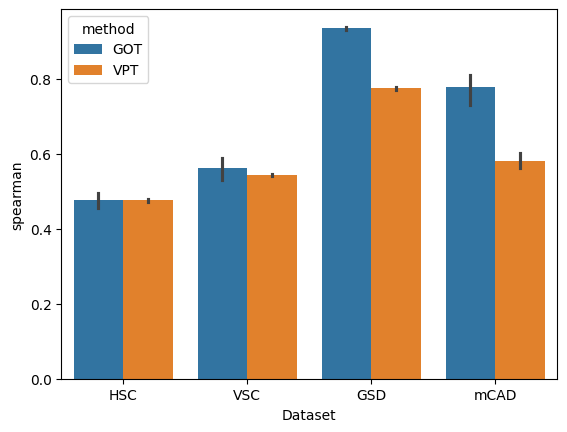

In [9]:
plot_result = pd.DataFrame(curated_results, columns=['Dataset', 'method', 'pearson', 'spearman'])
sns.barplot(plot_result, hue='method', y='spearman', x='Dataset', hue_order=['GOT', "VPT"])
plt.show()

In [15]:
plot_result.to_csv('./results/02_pseudotime/curated_results.csv')

In [16]:
curated_results = pd.read_csv('./results/02_pseudotime/curated_results.csv', index_col=0)
curated_results

Dataset method   pearson  spearman
0       HSC    VPT  0.425662  0.489557
1       HSC    GOT  0.611494  0.540980
2       HSC    VPT  0.414549  0.490628
3       HSC    GOT  0.414967  0.440054
4       HSC    VPT  0.415157  0.470068
..      ...    ...       ...       ...
155    mCAD    GOT  0.847877  0.774949
156    mCAD    VPT  0.718480  0.669134
157    mCAD    GOT  0.854117  0.816604
158    mCAD    VPT  0.681902  0.609184
159    mCAD    GOT  0.831802  0.780985

[160 rows x 4 columns]

In [17]:
i = 0
print(datasets[i])
adata = sc.read('./results/02_pseudotime/'+datasets[i]+'_normal.h5ad')


HSC


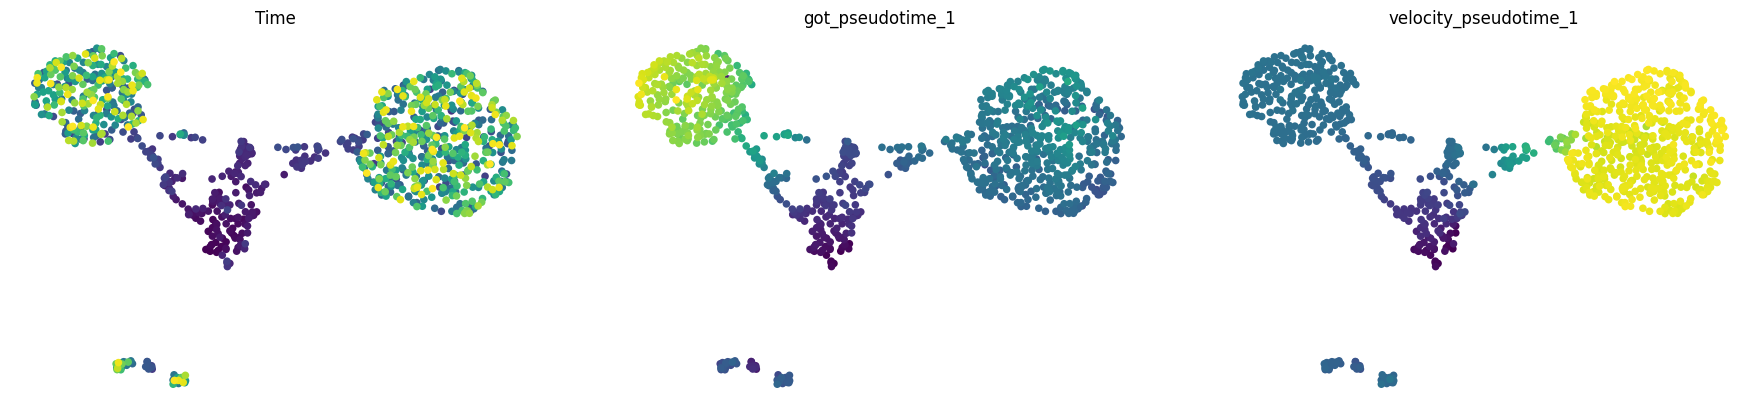

In [18]:
#upper_bound = 3*np.std(adata.obs['got_pseudotime_1'])+ np.mean(adata.obs['got_pseudotime_1'])
#lower_bound = -3*np.std(adata.obs['got_pseudotime_1'])+ np.mean(adata.obs['got_pseudotime_1'])
sc.pl.umap(adata, color=['Time', 'got_pseudotime_1', 'velocity_pseudotime_1'], 
           
           frameon=False,  colorbar_loc=None, show=False)
plt.savefig('/disk/share/xuruihong/pygot_fig/pseudotime_curated_example.jpg', dpi=500, format='jpg')

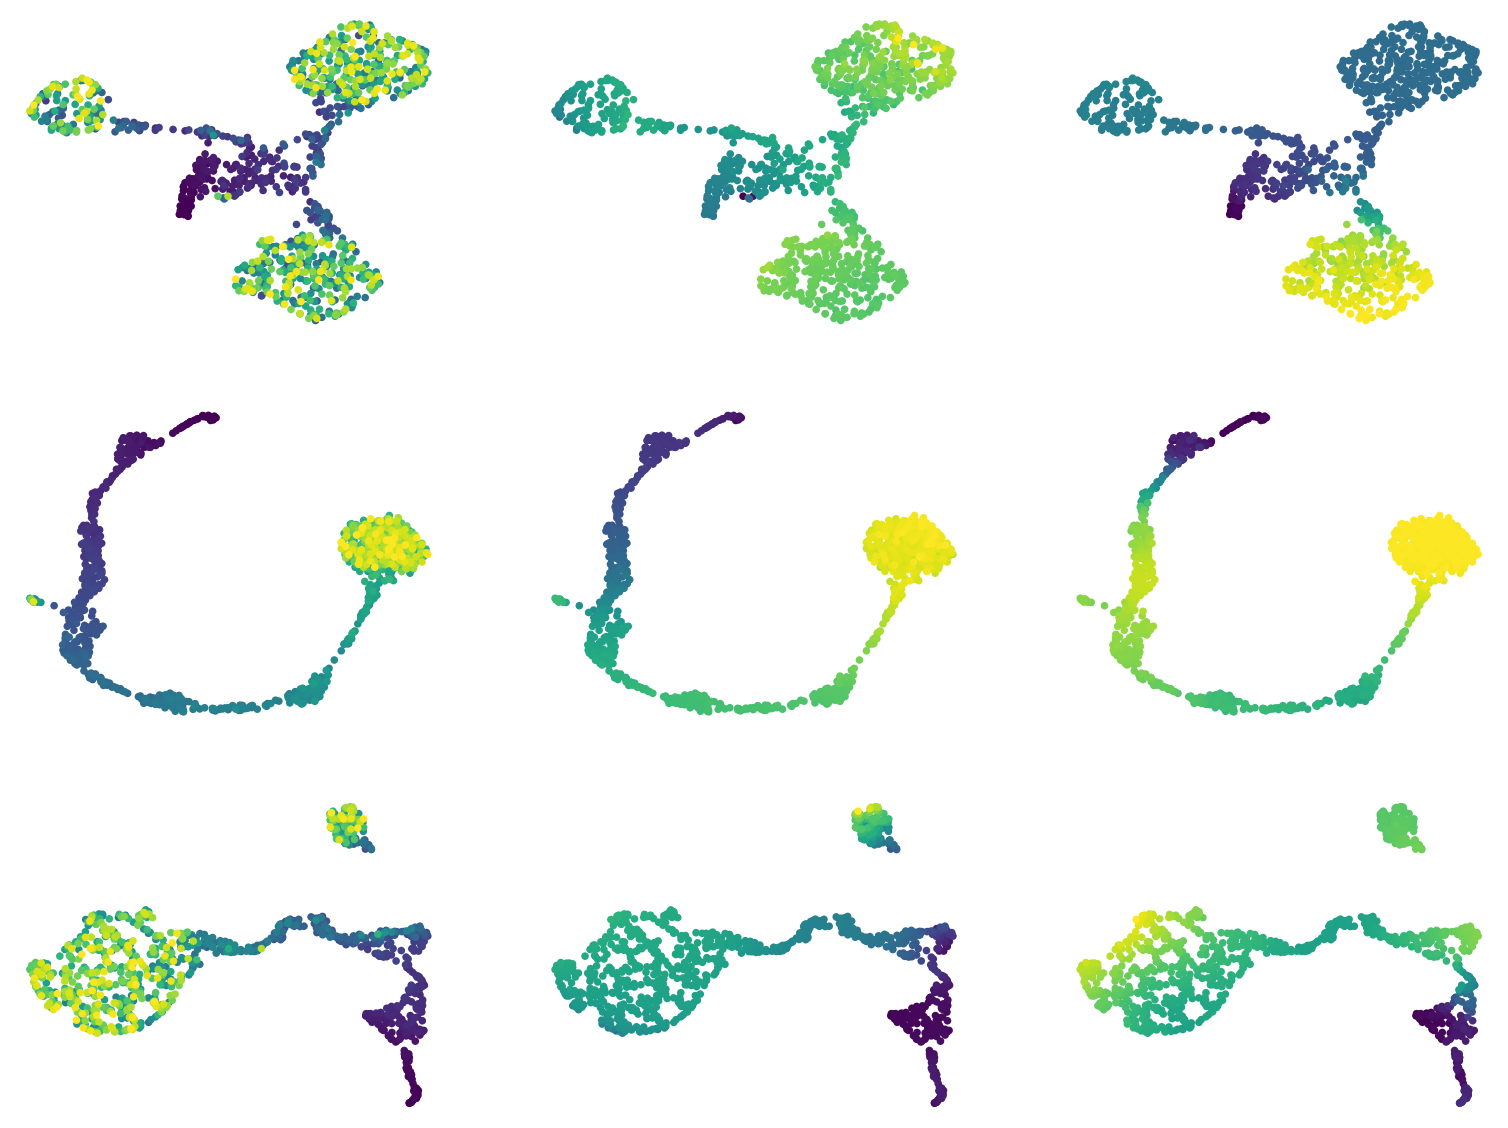

In [19]:
datasets =  [ 'VSC', 'GSD', 'mCAD']
fig, axes = plt.subplots(len(datasets), 3, figsize=(6.4*3 , 4.8 * len(datasets) ))
for i in range(len(datasets)):
    
    adata = sc.read('./results/02_pseudotime/'+datasets[i]+'_normal.h5ad')
    
    sc.pl.umap(adata, color='Time', ax=axes[i][0],  title='', show=False, colorbar_loc=None, frameon=False)
    sc.pl.umap(adata, color='got_pseudotime_1', title='', ax=axes[i][1], show=False, colorbar_loc=None, frameon=False)
    sc.pl.umap(adata, color='velocity_pseudotime_1', title='', ax=axes[i][2], show=False, colorbar_loc=None, frameon=False)
plt.show()

## scRNA-seq

### beta

In [20]:
adata = sc.read_h5ad('../pygot_data/IVB.h5ad')
pcaer = torch.load('../pygot_data/beta_diff/pcaer.pt')


In [21]:
time_key = 'CellWeek'
cell_type_key = 'Assigned_cluster'
embedding_key = 'X_pca'
cell_time = adata.obs[time_key].to_numpy()

In [22]:
time_key = 'CellWeek'
velocity_key = 'velocity_pca'
embedding_key = 'X_pca'
cell_type_key = "cell_type"
sc.pp.neighbors(adata, use_rep=embedding_key, n_neighbors=30)

In [23]:
beta_results = []
adata.layers['Ms'] = adata.X
for j in range(20):
    model = torch.load('./benchmark_model/models/GOT/02_holdout/veres19/veres19_{}.pkl'.format(j), map_location=device)
    adata.obsm[velocity_key] = pygot.tl.traj.latent_velocity(adata, model, embedding_key, time_key=time_key,)
    
    #VPT
    pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
    scv.tl.velocity_pseudotime(adata)
    
    vpt_p = pearsonr(adata.obs['velocity_pseudotime'], adata.obs[time_key])[0]
    vpt_s = spearmanr(adata.obs['velocity_pseudotime'], adata.obs[time_key])[0]
    print(vpt_p, vpt_s)
    beta_results.append(['VPT',  vpt_p, vpt_s])
    adata.obs['velocity_pseudotime_{}'.format(j)] = adata.obs['velocity_pseudotime'].copy()
    if 'velocity_self_transition' in adata.obs.columns:
        del adata.obs['velocity_self_transition']
    del adata.obs['root_cells']
    del adata.obs['end_points']
    #GOT
    pm = ProbabilityModel()
    pm.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key,  marginal=False, n_iters=500)
    adata.obs['got_pseudotime_{}'.format(j)] = pm.estimate_pseudotime(adata, mode='mean')
    got_p = pearsonr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs[time_key])[0]
    got_s = spearmanr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs[time_key])[0]
    print(got_p, got_s)
    beta_results.append(['GOT', got_p, got_s])

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:22) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3325194285657711 0.2733515807575851
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1529: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.56it/s]


0.6648803105128258 0.6837542390187874
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 4 regions of end points .
    finished (0:00:18) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.33191872834260827 0.27725059141477
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2559: 100%|██████████████████████████████████████| 500/500 [00:31<00:00, 16.03it/s]


0.6785517208391741 0.7093562225386842
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3338426189699568 0.28916561541065106
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1661: 100%|██████████████████████████████████████| 500/500 [00:31<00:00, 15.74it/s]


0.6681488365919305 0.7009471424394838
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:16) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3324678766295734 0.282832234404409
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2074: 100%|██████████████████████████████████████| 500/500 [00:30<00:00, 16.14it/s]


0.6741509975841874 0.7012155929564728
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:13) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.33047920252643337 0.27400258641570885
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2121: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.28it/s]


0.6765621608168207 0.6981072071220383
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:06) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3308566585022363 0.27100847409343953
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1469: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.47it/s]


0.6504484372689817 0.6775582420948448
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:15) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3398540987394685 0.3168249008948118
Device: cuda


Density Loss 0.0000, Taylor Loss 0.2014: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 14.78it/s]


0.6569575129571655 0.6728936042799927
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:10) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3365543453531721 0.3065154313987636
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1875: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.37it/s]


0.656107712420261 0.6776275874826992
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 4 regions of end points .
    finished (0:00:18) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3313347602525005 0.2718311915944845
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1533: 100%|██████████████████████████████████████| 500/500 [00:31<00:00, 15.68it/s]


0.6619999999843631 0.6783268155394133
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:07) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.33256763197330524 0.27522553276985573
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1547: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.51it/s]


0.6609453372452901 0.6767350814822573
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:06) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3352973258289716 0.30165107961998017
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1906: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.25it/s]


0.6830256523855047 0.6946719390408713
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 4 regions of end points .
    finished (0:00:09) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.332943942720614 0.2792665311511736
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1741: 100%|██████████████████████████████████████| 500/500 [00:31<00:00, 15.88it/s]


0.658987517610323 0.6725721451209833
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:20) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.33729694911778657 0.29324677968753265
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1787: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 15.11it/s]


0.6688620291644296 0.679784568701279
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:11) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3314451740373285 0.2774645657726638
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1833: 100%|██████████████████████████████████████| 500/500 [00:33<00:00, 15.03it/s]


0.6813158301021907 0.6958170755214675
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
-0.017660471543456395 -0.11825484172521925
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1829: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.40it/s]


0.6868867959072349 0.7026522368927692
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:13) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.33349335490148957 0.2863748787565845
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1793: 100%|██████████████████████████████████████| 500/500 [00:31<00:00, 15.99it/s]


0.6610101271982979 0.6737178347085435
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 4 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3327642720886091 0.2809115636633609
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1679: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.53it/s]


0.6706449937813054 0.695028282508197
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:11) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3335668143966826 0.2712994276387072
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1497: 100%|██████████████████████████████████████| 500/500 [00:31<00:00, 15.64it/s]


0.6475698967238684 0.6571883538268757
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:19) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.3297421754117452 0.26883405250017606
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1598: 100%|██████████████████████████████████████| 500/500 [00:32<00:00, 15.54it/s]


0.6497803551218644 0.6620232485182213
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:13) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.33123320793481204 0.2694824587697914
Device: cuda


Density Loss 0.0000, Taylor Loss 0.1587: 100%|██████████████████████████████████████| 500/500 [00:31<00:00, 15.64it/s]


0.6773478546482293 0.704071767109985


In [24]:
beta_df = pd.DataFrame(beta_results, columns=['method', 'pearson', 'spearman'])
beta_df['Dataset'] = 'IVB'

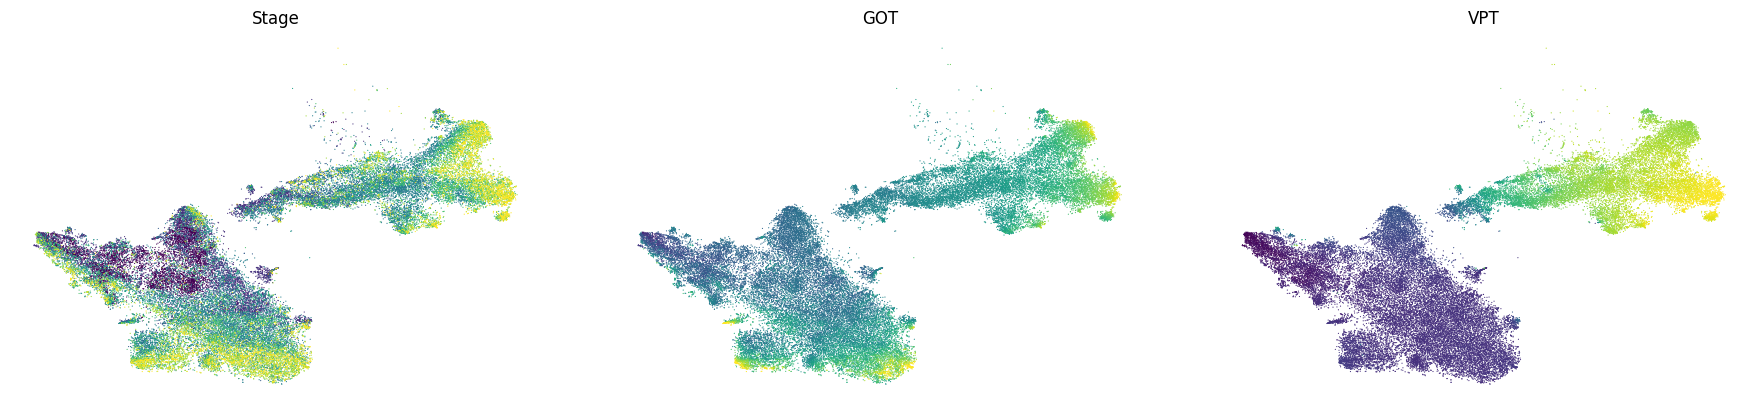

In [25]:
upper_bound = 3*np.std(adata.obs['got_pseudotime_0'])+ np.mean(adata.obs['got_pseudotime_0'])
lower_bound = -3*np.std(adata.obs['got_pseudotime_0'])+ np.mean(adata.obs['got_pseudotime_0'])
adata.obs[time_key] = adata.obs[time_key].astype(int)
sc.pl.embedding(adata, color=[time_key, 'got_pseudotime_0','velocity_pseudotime_0'], basis='tsne', vmax=[adata.obs[time_key].max(), upper_bound, 1.0],
                vmin=[adata.obs[time_key].min(), lower_bound, 0.],
                title=['Stage', 'GOT', 'VPT'], frameon=False, colorbar_loc=None, show=False)
plt.savefig('/disk/share/xuruihong/pygot_fig/pseudotime_example3.jpg', dpi=500, format='jpg')

### iPSC

In [26]:
adata = sc.read('../pygot_data/iPSC.h5ad')

In [27]:
adata
time_key = 'day'
embedding_key = 'X_pca'
adata.obs['stage_numeric'] = adata.obs[time_key].replace(dict(zip(np.sort(adata.obs[time_key].unique()), range(len(np.unique(adata.obs[time_key])))))).astype(int)
time_key = 'stage_numeric'
cell_time = adata.obs[time_key].to_numpy()

In [28]:
time_key = 'stage_numeric'
velocity_key = 'velocity_pca'
embedding_key = 'X_pca'
cell_type_key = "cell_type"
sc.pp.neighbors(adata, use_rep=embedding_key, n_neighbors=30)

In [29]:
ipsc_results = []
adata.layers['Ms'] = adata.X
for j in range(20):
    model = torch.load('./benchmark_model/GOT/02_holdout/cell19/cell19_{}.pkl'.format(j), map_location=device)
    adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model, embedding_key, time_key=time_key)
    
    #VPT
    pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
    scv.tl.velocity_pseudotime(adata)
    
    vpt_p = pearsonr(adata.obs['velocity_pseudotime'], adata.obs[time_key])[0]
    vpt_s = spearmanr(adata.obs['velocity_pseudotime'], adata.obs[time_key])[0]
    print(vpt_p, vpt_s)
    ipsc_results.append(['VPT',  vpt_p, vpt_s])
    adata.obs['velocity_pseudotime_{}'.format(j)] = adata.obs['velocity_pseudotime'].copy()
    if 'velocity_self_transition' in adata.obs.columns:
        del adata.obs['velocity_self_transition']
    del adata.obs['root_cells']
    del adata.obs['end_points']
    #GOT
    pm = ProbabilityModel()
    pm.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key,  marginal=False, n_iters=500)
    adata.obs['got_pseudotime_{}'.format(j)] = pm.estimate_pseudotime(adata, mode='mean')
    adata.obs['got_pseudotime_{}'.format(j)] = (adata.obs['got_pseudotime_{}'.format(j)] - np.min(adata.obs['got_pseudotime_{}'.format(j)])) / \
            (np.max(adata.obs['got_pseudotime_{}'.format(j)]) - np.min(adata.obs['got_pseudotime_{}'.format(j)]))
    got_p = pearsonr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs[time_key])[0]
    got_s = spearmanr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs[time_key])[0]
    print(got_p, got_s)
    ipsc_results.append(['GOT', got_p, got_s])

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:41) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6512759547134542 0.9503441833677465
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3728: 100%|██████████████████████████████████████| 500/500 [00:40<00:00, 12.32it/s]


0.8578630392597675 0.9376982969270012
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:35) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6599961835963742 0.9539115376740157
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3892: 100%|██████████████████████████████████████| 500/500 [00:38<00:00, 12.90it/s]


0.8344031593423291 0.918894511117041
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:31) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6579264019220451 0.9514174346168014
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3793: 100%|██████████████████████████████████████| 500/500 [00:40<00:00, 12.29it/s]


0.8422682282231385 0.930636808093465
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:29) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6587457469900699 0.951115529962472
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3216: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.57it/s]


0.8667482862519973 0.9366855654124271
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:33) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6574683219457735 0.9507369895061031
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3809: 100%|██████████████████████████████████████| 500/500 [00:38<00:00, 13.14it/s]


0.8968190759026653 0.9538382552923675
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:25) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6573239645074302 0.9524494861839837
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3891: 100%|██████████████████████████████████████| 500/500 [00:38<00:00, 12.83it/s]


0.840826927031351 0.9395745059622758
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:23) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6617983169128692 0.9527213292754165
Device: cuda


Density Loss 0.0000, Taylor Loss 0.4143: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.51it/s]


0.8673217721053812 0.9331505772884428
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:15) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6680266772082198 0.9537170623343161
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3833: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.67it/s]


0.8528682053129891 0.9367443307656704
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:31) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6625377582303253 0.9546363981060066
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3539: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.54it/s]


0.8632923767099853 0.9307565585974538
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:29) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6611997399389353 0.9512919179211894
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3721: 100%|██████████████████████████████████████| 500/500 [00:40<00:00, 12.45it/s]


0.8389273119406571 0.9183465201531297
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:34) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6594304789981377 0.9510217469248335
Device: cuda


Density Loss 0.0000, Taylor Loss 0.4915: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.51it/s]


0.869964851271511 0.9362853162199218
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:17) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6628373904741066 0.9512197414903504
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3935: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.56it/s]


0.853153336664564 0.9340319731562947
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:41) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6570212909340266 0.952467313503831
Device: cuda


Density Loss 0.0000, Taylor Loss 0.4078: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.51it/s]


0.8464669989094937 0.9280018769688693
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:31) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6692372892313795 0.9491951430885386
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3673: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.53it/s]


0.8616729780807646 0.9316652806432503
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:13) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6562270912851426 0.9516906194487759
Device: cuda


Density Loss 0.0000, Taylor Loss 0.4011: 100%|██████████████████████████████████████| 500/500 [00:41<00:00, 12.19it/s]


0.8482120102106259 0.9218245028594845
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:29) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6531603661164298 0.9512870089217499
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3894: 100%|██████████████████████████████████████| 500/500 [00:40<00:00, 12.21it/s]


0.8723002100763482 0.9279881843988688
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:35) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6635031397925854 0.9515177365546648
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3671: 100%|██████████████████████████████████████| 500/500 [00:51<00:00,  9.62it/s]


0.8485758604353526 0.9255925630333803
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:18) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6652282805271094 0.9524177898484883
Device: cuda


Density Loss 0.0000, Taylor Loss 0.4001: 100%|██████████████████████████████████████| 500/500 [00:50<00:00,  9.98it/s]


0.8409417975590621 0.9245117116969672
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:25) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6575965491627608 0.9546227482073351
Device: cuda


Density Loss 0.0000, Taylor Loss 0.5332: 100%|██████████████████████████████████████| 500/500 [00:55<00:00,  9.03it/s]


0.8388845021559513 0.9107604467817756
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:29) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.6616414587703402 0.9524703817285498
Device: cuda


Density Loss 0.0000, Taylor Loss 0.3787: 100%|██████████████████████████████████████| 500/500 [00:42<00:00, 11.88it/s]


0.8572925839849852 0.9118274326607199


In [30]:
ipsc_df = pd.DataFrame(ipsc_results, columns=['method', 'pearson', 'spearman'])
ipsc_df['Dataset'] = 'iPSC'

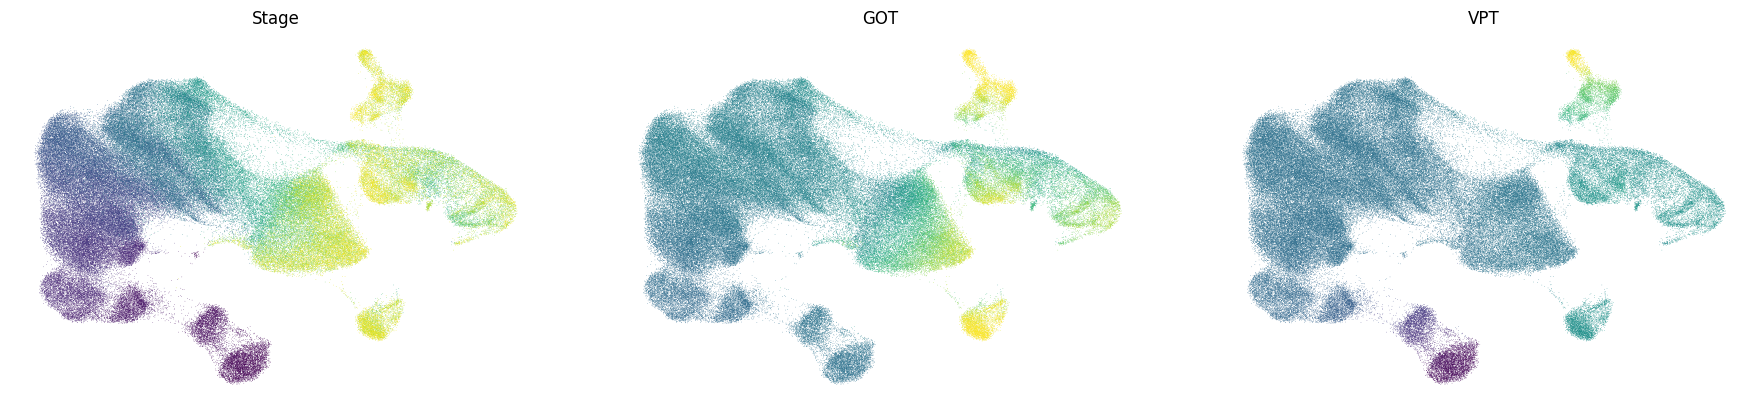

In [31]:
upper_bound = 3*np.std(adata.obs['got_pseudotime_0'])+ np.mean(adata.obs['got_pseudotime_0'])
lower_bound = -3*np.std(adata.obs['got_pseudotime_0'])+ np.mean(adata.obs['got_pseudotime_0'])
adata.obs[time_key] = adata.obs[time_key].astype(int)
sc.pl.embedding(adata, color=[time_key, 'got_pseudotime_0','velocity_pseudotime_0'], basis='umap', vmax=[adata.obs[time_key].max(), upper_bound, 1.0],
                vmin=[adata.obs[time_key].min(), lower_bound, 0.],
                title=['Stage', 'GOT', 'VPT'], frameon=False, colorbar_loc=None, show=False)
plt.savefig('/disk/share/xuruihong/pygot_fig/pseudotime_example2.jpg', dpi=500, format='jpg')

### Gastrulation

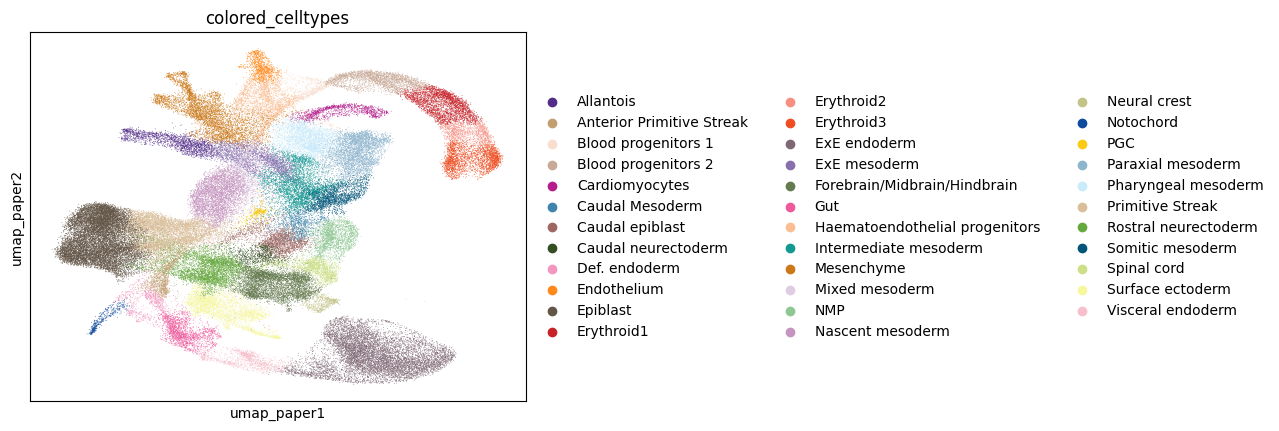

In [32]:
adata = sc.read('../pygot_data/GTL.h5ad')
sc.pl.embedding(adata, basis="umap_paper", color="colored_celltypes")
adata.obs['stage_numeric'] = adata.obs['stage'].apply(lambda x: float(x[1:]))
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(np.float32)

In [33]:
time_key = 'stage_numeric'
velocity_key = 'velocity_pca'
embedding_key = 'X_pca'
cell_type_key = "colored_celltypes"
adata = adata[:,adata.var['highly_variable']]
sc.pp.neighbors(adata, use_rep=embedding_key, n_neighbors=30)

In [34]:
gas_results = []
adata.layers['Ms'] = adata.X
for j in range(20):
    model = torch.load('./benchmark_model/GOT/02_holdout/gastrulation/gas_{}.pkl'.format(j), map_location=device)
    adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model, embedding_key, time_key=time_key)
    
    #VPT
    pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key=velocity_key)
    scv.tl.velocity_pseudotime(adata)
    
    vpt_p = pearsonr(adata.obs['velocity_pseudotime'], adata.obs[time_key])[0]
    vpt_s = spearmanr(adata.obs['velocity_pseudotime'], adata.obs[time_key])[0]
    print(vpt_p, vpt_s)
    gas_results.append(['VPT',  vpt_p, vpt_s])
    adata.obs['velocity_pseudotime_{}'.format(j)] = adata.obs['velocity_pseudotime'].copy()
    if 'velocity_self_transition' in adata.obs.columns:
        del adata.obs['velocity_self_transition']
    del adata.obs['root_cells']
    del adata.obs['end_points']
    #GOT
    pm = ProbabilityModel()
    pm.fit(adata, embedding_key=embedding_key, velocity_key=velocity_key,  marginal=False, n_iters=500)
    adata.obs['got_pseudotime_{}'.format(j)] = pm.estimate_pseudotime(adata, mode='mean')
    
    got_p = pearsonr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs[time_key])[0]
    got_s = spearmanr(adata.obs['got_pseudotime_{}'.format(j)], adata.obs[time_key])[0]
    print(got_p, got_s)
    gas_results.append(['GOT', got_p, got_s])

Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 4 regions of end points .
    finished (0:00:08) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5471732490512342 0.5047548122236958
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0029: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.51it/s]


0.8301594951772111 0.8269257861259636
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:16) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5586731315738552 0.5197727160731521
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0035: 100%|██████████████████████████████████████| 500/500 [00:40<00:00, 12.39it/s]


0.850376610505175 0.8651707045739382
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:07) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5615411435753126 0.5316931446948999
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0040: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.51it/s]


0.7783920492924687 0.767847192384654
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:17) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5624704698118754 0.5290360981828202
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0036: 100%|██████████████████████████████████████| 500/500 [00:43<00:00, 11.52it/s]


0.8545214368031023 0.8639762596612718
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 4 regions of end points .
    finished (0:00:12) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5606804948769838 0.5346134089260655
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0039: 100%|██████████████████████████████████████| 500/500 [00:40<00:00, 12.39it/s]


0.8466240485536739 0.8551585655822143
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:14) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5584796371951367 0.5271613778291845
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0042: 100%|██████████████████████████████████████| 500/500 [00:41<00:00, 12.06it/s]


0.796889921389391 0.7875210829977797
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:08) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5556439421905096 0.5233345640331237
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0039: 100%|██████████████████████████████████████| 500/500 [00:38<00:00, 12.95it/s]


0.8084417323489468 0.8021458151077411
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:17) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5595344530230081 0.5345119202424752
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0027: 100%|██████████████████████████████████████| 500/500 [00:38<00:00, 13.05it/s]


0.8271689278957028 0.8262821682444801
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:16) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5489747775396057 0.518696120846282
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0031: 100%|██████████████████████████████████████| 500/500 [00:37<00:00, 13.49it/s]


0.844928711375541 0.8523145752069006
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:16) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.7719576255491534 0.8252004201938415
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0036: 100%|██████████████████████████████████████| 500/500 [00:40<00:00, 12.45it/s]


0.8187638712136844 0.8205931545285368
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:16) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5551403810829901 0.5236422826639204
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0050: 100%|██████████████████████████████████████| 500/500 [00:37<00:00, 13.44it/s]


0.8112537486395714 0.8161398871839621
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:17) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5578653448430413 0.5202574909245724
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0027: 100%|██████████████████████████████████████| 500/500 [00:38<00:00, 13.09it/s]


0.8372284888847882 0.8429466539719095
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 4 regions of end points .
    finished (0:00:07) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5596347285623695 0.5209273725802636
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0026: 100%|██████████████████████████████████████| 500/500 [00:38<00:00, 12.97it/s]


0.8133133627513384 0.80362506344725
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 4 regions of end points .
    finished (0:00:16) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5578414356848166 0.5332150559878056
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0026: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.76it/s]


0.8496195145028954 0.85180316931563
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:12) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5649200715621286 0.5348203126398019
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0034: 100%|██████████████████████████████████████| 500/500 [00:37<00:00, 13.24it/s]


0.8339360082745569 0.850350113598291
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:13) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5591027312204314 0.5321009632805046
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0031: 100%|██████████████████████████████████████| 500/500 [00:37<00:00, 13.46it/s]


0.7892479180740533 0.7795777720391708
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:17) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5537896318922851 0.5326272407313162
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0035: 100%|██████████████████████████████████████| 500/500 [00:39<00:00, 12.52it/s]


0.8704834083153963 0.9025218877979767
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:14) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5514089784384237 0.505019149850119
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0030: 100%|██████████████████████████████████████| 500/500 [00:37<00:00, 13.48it/s]


0.8117732318854516 0.7991374615218727
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 4 regions of end points .
    finished (0:00:16) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5521503597227194 0.5157548651800589
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0029: 100%|██████████████████████████████████████| 500/500 [00:38<00:00, 13.02it/s]


0.8316923899098094 0.8299781831513687
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing terminal states
    identified 1 region of root cells and 5 regions of end points .
    finished (0:00:17) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
0.5623507476947751 0.5236972566441582
Device: cuda


Density Loss 0.0000, Taylor Loss 0.0025: 100%|██████████████████████████████████████| 500/500 [00:37<00:00, 13.28it/s]


0.7866481758812701 0.7723897508904549


In [35]:
gas_df = pd.DataFrame(gas_results, columns=['method', 'pearson', 'spearman'])
gas_df['Dataset'] = 'GTL'

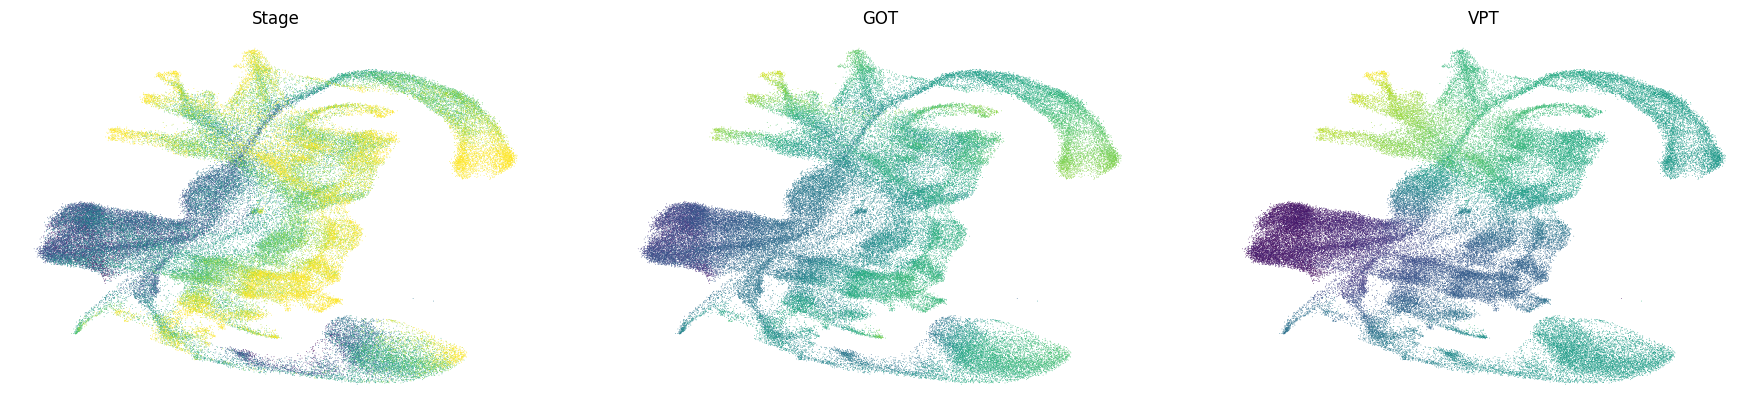

In [36]:
upper_bound = 3*np.std(adata.obs['got_pseudotime_0'])+ np.mean(adata.obs['got_pseudotime_0'])
lower_bound = -3*np.std(adata.obs['got_pseudotime_0'])+ np.mean(adata.obs['got_pseudotime_0'])
adata.obs[time_key] = adata.obs[time_key].astype(float)
sc.pl.embedding(adata, color=[time_key, 'got_pseudotime_0','velocity_pseudotime_0'], basis='umap_paper', vmax=[None, upper_bound, 1.0],
                vmin=[None, lower_bound, 0.],
                title=['Stage', 'GOT', 'VPT'], frameon=False, colorbar_loc=None, show=False)
plt.savefig('/disk/share/xuruihong/pygot_fig/pseudotime_example1.jpg', dpi=500, format='jpg')

In [37]:
scRNA_res = pd.concat([beta_df, gas_df, ipsc_df])

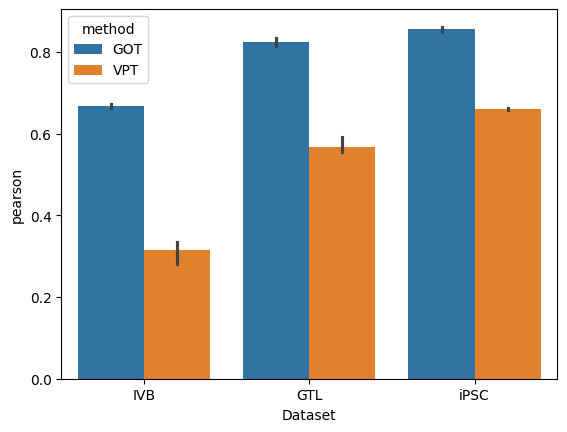

In [38]:
plot_result = pd.DataFrame(scRNA_res, columns=['Dataset', 'method', 'pearson', 'spearman'])
sns.barplot(plot_result, hue='method', y='pearson', x='Dataset', hue_order=['GOT', "VPT"])
plt.show()

In [39]:
plot_result.to_csv('./results/02_pseudotime/scRNA_results.csv')

In [40]:
scRNA_res = pd.read_csv('./results/02_pseudotime/scRNA_results.csv')

## Combine All

In [41]:
import mplscience
mplscience.set_style(reset_current=True)

pal=sns.color_palette()
paln=pal.copy()
paln[0]=np.array([13,111,178])/255
plt.rcParams['font.sans-serif'] = ['Arial']

In [42]:
plot_result = pd.concat([pd.DataFrame(scRNA_res, columns=['Dataset', 'method', 'pearson', 'spearman']),
                         pd.DataFrame(synthetic_results, columns=['Dataset', 'method', 'pearson', 'spearman']),
                         pd.DataFrame(curated_results, columns=['Dataset', 'method', 'pearson', 'spearman'])]).reset_index(drop=True)
plot_result                         

Dataset method   pearson  spearman
0       IVB    VPT  0.332519  0.273352
1       IVB    GOT  0.664880  0.683754
2       IVB    VPT  0.331919  0.277251
3       IVB    GOT  0.678552  0.709356
4       IVB    VPT  0.333843  0.289166
..      ...    ...       ...       ...
515    mCAD    GOT  0.847877  0.774949
516    mCAD    VPT  0.718480  0.669134
517    mCAD    GOT  0.854117  0.816604
518    mCAD    VPT  0.681902  0.609184
519    mCAD    GOT  0.831802  0.780985

[520 rows x 4 columns]

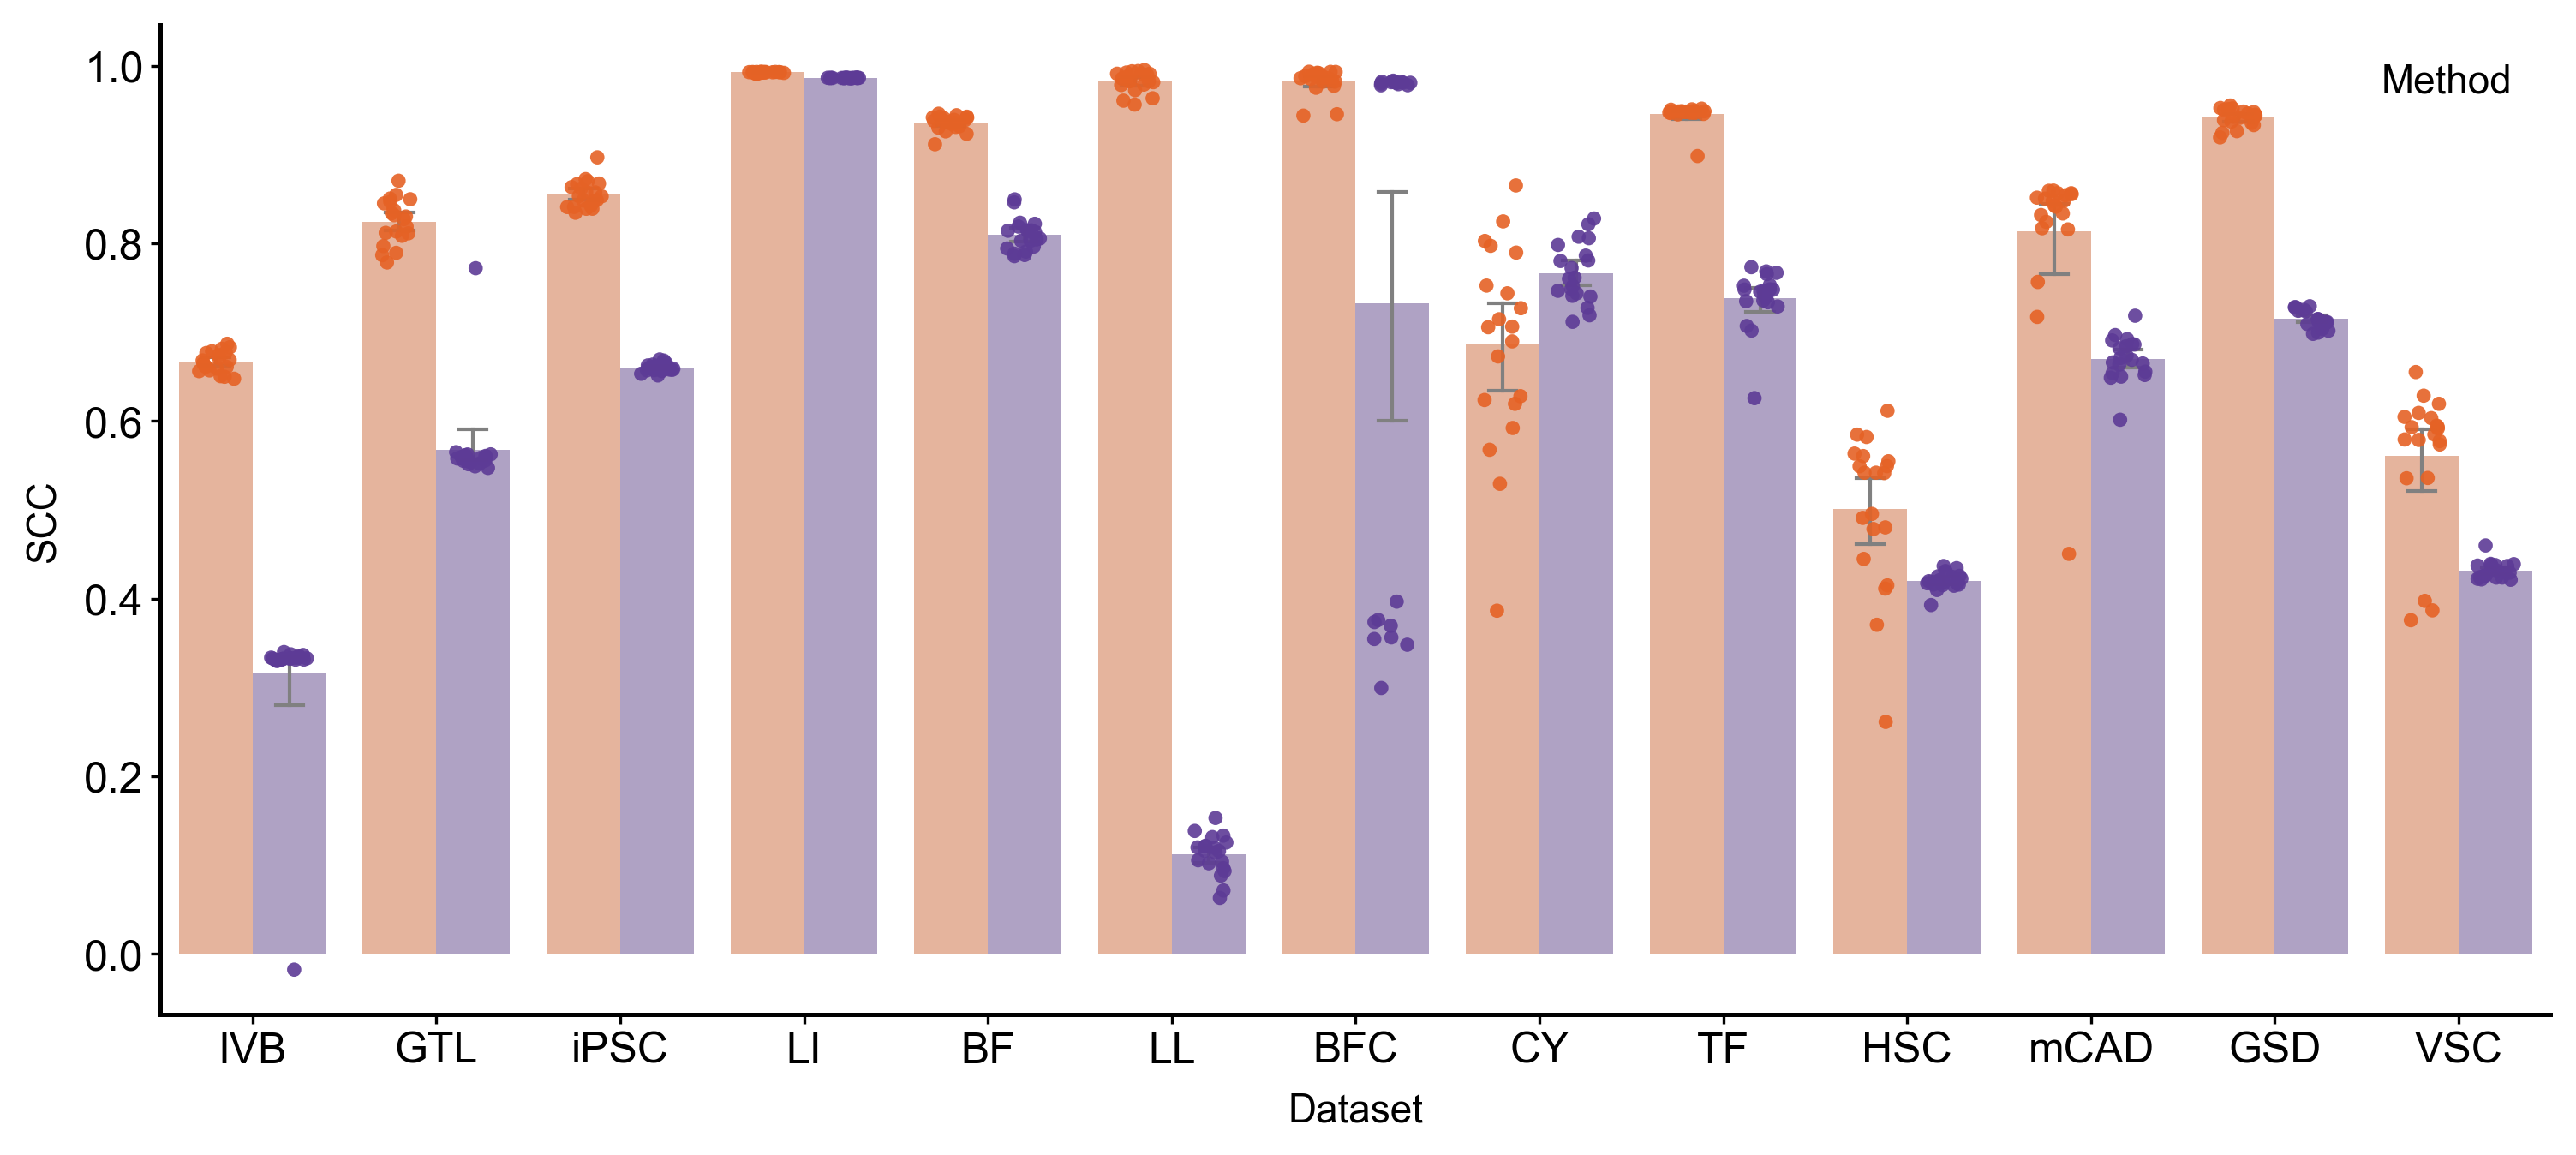

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 假设 plot_result 是您的 DataFrame
plt.figure(figsize=(12, 5), dpi=300)
palette = {
    'GOT':'#e56225',
    'VPT':'#5d3b96'
}
# 先画条形图
ax = sns.barplot(
    data=plot_result,
    x='Dataset', 
    y='pearson',
    hue='method',
    hue_order=['GOT', 'VPT'],
    capsize=.3,
    err_kws={"linewidth": 1., 'color':'grey'},
    palette=palette,
    order=['IVB', 'GTL', 'iPSC', 'LI', 'BF', 'LL', 'BFC', 'CY', 'TF',  'HSC', 'mCAD', 'GSD', 'VSC'],
    #fill=False,
    legend=False,
    alpha=0.5
    
)

# 再叠加抖动点图
sns.stripplot(
    data=plot_result,
    x='Dataset', 
    y='pearson',
    hue='method',
    hue_order=['GOT', 'VPT'],
    dodge=True,  # 分开展示不同方法
    jitter=0.2,  # 控制抖动幅度
    palette=palette, 
    alpha=.9,
    legend=False,
    #ax=ax,
    size=4,
    order=['IVB', 'GTL', 'iPSC', 'LI', 'BF', 'LL', 'BFC', 'CY', 'TF',  'HSC', 'mCAD', 'GSD', 'VSC']
)

# 处理图例重复问题
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Method')  # 只保留条形图的图例
plt.ylabel('SCC')
#plt.savefig('/disk/share/xuruihong/pygot_fig/benchmark_pseudotime.pdf', format='pdf')
plt.show()